In [1]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive/Colab Notebooks/synprivutil-main

Mounted at /content/drive
/content/drive/MyDrive/Colab Notebooks/synprivutil-main


In [2]:
!pip install numpy==1.26.4 pandas==2.2.2 sdv==1.15.0 scikit-learn==1.5.1 seaborn==0.12.2 matplotlib==3.9.2 rdt==1.12.3 anonymeter==1.0.0 scipy==1.13.0 dython==0.7.8 POT==0.9.4


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 146.4/146.4 kB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.4/13.4 MB 87.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 293.3/293.3 kB 24.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 93.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.2/65.2 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 45.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 835.4/835.4 kB 42.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.2/139.2 kB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 84.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.4/52.4 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 67.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.1

## ML utility

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso, BayesianRidge
from sklearn.metrics import mean_absolute_percentage_error
import numpy as np

def calculate_ml_utility_rf_linked_improved(original, synthetic, target_column):
    """
    Evaluate machine learning utility by linking synthetic data to original data
    using four regression models and calculating the average MAPE.

    Parameters:
        original (pd.DataFrame): Original dataset.
        synthetic (pd.DataFrame): Synthetic dataset.
        target_column (str): The target column for prediction.

    Returns:
        dict: Average MAPE for STO and OTS scenarios across four regression models.
    """
    # Step 1: Split original data into training and testing sets
    # X_orig = original.drop(columns=[target_column])
    # y_orig = original[target_column]
    # X_train_orig, X_test_orig, y_train_orig, y_test_orig = train_test_split(
    #     X_orig, y_orig, test_size=0.2, random_state=42)
    X_test_orig = original.drop(columns=[target_column])
    y_test_orig = original[target_column]

    # Step 2: Prepare synthetic data
    X_syn = synthetic.drop(columns=[target_column])
    y_syn = synthetic[target_column]
    # X_train_syn, X_test_syn, y_train_syn, y_test_syn = train_test_split(
    #     X_syn, y_syn, test_size=0.2, random_state=42)

    # Regression models
    models = [LinearRegression(), Ridge(), Lasso(), BayesianRidge()]

    # Collect MAPEs for STO and OTS
    sto_mape_list = []
    # ots_mape_list = []

    for model in models:
        # Train on synthetic data, test on original data
        model.fit(X_syn, y_syn)
        y_pred_syn_on_orig = model.predict(X_test_orig)
        sto_mape = mean_absolute_percentage_error(y_test_orig, y_pred_syn_on_orig)
        sto_mape_list.append(sto_mape)

        # # Train on original data, test on synthetic data
        # model.fit(X_train_orig, y_train_orig)
        # y_pred_orig_on_syn = model.predict(X_test_syn)
        # ots_mape = mean_absolute_percentage_error(y_test_syn, y_pred_orig_on_syn)
        # ots_mape_list.append(ots_mape)

    # Average MAPEs
    avg_sto_mape = np.mean(sto_mape_list)
    # avg_ots_mape = np.mean(ots_mape_list)

    metrics = {
        "MAPE_syn": avg_sto_mape,  # Train on synthetic, test on original
        # "MAPE_ori": avg_ots_mape   # Train on original, test on synthetic
    }

    return metrics


In [4]:
def replace_outliers_with_mean(original_data, synthetic_data, synthetic_name, threshold=1):
    total_replacements = 0  

    for column in synthetic_data.columns:
        if column in original_data.columns:
            # Use max and min with std range to determine abnormal value
            orig_mean = original_data[column].median()
            orig_max = original_data[column].max()
            orig_min = original_data[column].min()
            orig_std = original_data[column].std()

            lower_bound = orig_min - threshold * orig_std
            upper_bound = orig_max + threshold * orig_std

            replaced_column = synthetic_data[column].apply(
                lambda x: orig_mean if x < lower_bound or x > upper_bound else x
            )

            replacements = (synthetic_data[column] != replaced_column).sum()
            total_replacements += replacements

            synthetic_data[column] = replaced_column

    print(f"Under {synthetic_name} total replacements made: {total_replacements}")
    return synthetic_data


def remove_rows_with_outliers(original_data, synthetic_data, synthetic_name, threshold=1):

    rows_to_drop = set()

    for column in synthetic_data.columns:
        if column in original_data.columns:
      
            orig_mean = original_data[column].median()
            orig_max = original_data[column].max()
            orig_min = original_data[column].min()
            orig_std = original_data[column].std()

            lower_bound = orig_min - threshold * orig_std
            upper_bound = orig_max + threshold * orig_std

            outlier_indices = synthetic_data[(synthetic_data[column] < lower_bound) |
                                             (synthetic_data[column] > upper_bound)].index
            rows_to_drop.update(outlier_indices)

    rows_to_drop = list(rows_to_drop)  
    cleaned_data = synthetic_data.drop(index=rows_to_drop)

    print(f"Under {synthetic_name}, removed {len(rows_to_drop)} rows with outliers.")
    return cleaned_data


In [11]:
import os
import re
import gc
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict
from sklearn.preprocessing import MinMaxScaler
# Load original dataset
original_data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Tabula-main-claude/Real_Datasets/Insurance_test.csv")
original_name = "Insurance"

# Directory containing synthetic datasets
synthetic_folder = "/content/drive/MyDrive/Colab Notebooks/Tabula-main-claude/insurance_syn_data"

# Dictionary to store aggregated results
aggregated_results = defaultdict(lambda: defaultdict(list))

# Function to extract sigma value as float
def extract_sigma(file_name):
    match = re.search(r"sigma-(\d+)", file_name)
    if match:
        sigma_str = match.group(1)
        if len(sigma_str) == 1:  # Single digit like "1" -> "1"
            return int(sigma_str)
        elif len(sigma_str) == 2:  # Two digits like "05" -> "0.5"
            return int(sigma_str) / 10
        elif len(sigma_str) == 3:  # Three digits like "005" -> "0.05"
            return int(sigma_str) / 100
        elif len(sigma_str) == 4:  # Four digits like "0005" -> "0.005"
            return int(sigma_str) / 1000
    return None

target_column = "charges"  # Replace with your actual target column
task_type = "regression"  # "classification" or "regression"

# Loop through each synthetic file and perform calculations
for file_name in os.listdir(synthetic_folder):
    if file_name.endswith(".csv"):
        synthetic_path = os.path.join(synthetic_folder, file_name)
        synthetic_data = pd.read_csv(synthetic_path)

        # Ensure correct data types (e.g., convert 'age' column to int if needed)
        for column in synthetic_data.columns:
            if column in original_data.columns:
                # Convert the column type in synthetic data to match the original data
                synthetic_data[column] = synthetic_data[column].astype(original_data[column].dtype)


        sigma = extract_sigma(file_name)
        if sigma is None:
            continue  # Skip files without a valid sigma value
        # print(f"\nProcessing synthetic dataset: {file_name} (sigma: {sigma})")

        # synthetic_data = replace_outliers_with_mean(original_data, synthetic_data, sigma)
        synthetic_data = remove_rows_with_outliers(original_data, synthetic_data, sigma)
        # print(f"Under {sigma}, lines number {synthetic_data.shape[0]}")

        # Step 1: Calculate ML utility
        ml_results = calculate_ml_utility_rf_linked_improved(original_data, synthetic_data, target_column)

        # Step 2: Add metrics to aggregated_results
        for category, metric_value in ml_results.items():
            aggregated_results[sigma][category].append(metric_value)

        # Cleanup
        del synthetic_data
        gc.collect()



# Step 3: Calculate average metrics for each sigma
averaged_results = defaultdict(dict)
for sigma, metrics in aggregated_results.items():
    for metric, values in metrics.items():
        averaged_results[sigma][metric] = np.mean(values)

# Step 4: Convert averaged_results into a DataFrame
final_results = defaultdict(list)
for sigma, metrics in averaged_results.items():
    final_results["sigma"].append(sigma)
    for metric, value in metrics.items():
        final_results[metric].append(value)

df = pd.DataFrame(final_results)

# Sort the DataFrame by sigma
df = df.sort_values(by="sigma").reset_index(drop=True)

# Step 5: Print and verify the DataFrame
print(df)


Under 0.0, removed 7 rows with outliers.
Under 0.05, removed 12 rows with outliers.
Under 0.1, removed 33 rows with outliers.
Under 0.15, removed 44 rows with outliers.
Under 0.2, removed 47 rows with outliers.
Under 0.25, removed 86 rows with outliers.
Under 0.3, removed 70 rows with outliers.
Under 0.35, removed 107 rows with outliers.
Under 0.4, removed 160 rows with outliers.
Under 0.45, removed 155 rows with outliers.
Under 0.5, removed 170 rows with outliers.
Under 0.03, removed 15 rows with outliers.
Under 0.04, removed 16 rows with outliers.
Under 0.016, removed 3 rows with outliers.
Under 0.014, removed 5 rows with outliers.
Under 0.01, removed 5 rows with outliers.
Under 0.012, removed 10 rows with outliers.
Under 0.02, removed 7 rows with outliers.
    sigma  MAPE_syn
0   0.000  0.500289
1   0.010  0.534838
2   0.012  0.797315
3   0.014  0.917566
4   0.016  1.046045
5   0.020  1.157543
6   0.030  1.321521
7   0.040  1.466033
8   0.050  1.408701
9   0.100  1.454733
10  0.150 

## Privacy and utility evaluations

### original

In [8]:
import os
import re
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict
from sklearn.preprocessing import MinMaxScaler
from privacy_utility_framework.privacy_utility_framework.metrics.utility_metrics.utility_metric_manager import UtilityMetricManager
from privacy_utility_framework.privacy_utility_framework.metrics.utility_metrics.statistical.basic_stats import BasicStatsCalculator
from privacy_utility_framework.privacy_utility_framework.metrics.utility_metrics.statistical.mutual_information import MICalculator
from privacy_utility_framework.privacy_utility_framework.metrics.utility_metrics.statistical.correlation import CorrelationCalculator
from privacy_utility_framework.privacy_utility_framework.metrics.utility_metrics.statistical.js_similarity import JSCalculator
from privacy_utility_framework.privacy_utility_framework.metrics.privacy_metrics.privacy_metric_manager import PrivacyMetricManager
from privacy_utility_framework.privacy_utility_framework.metrics.privacy_metrics.distance.adversarial_accuracy_class import AdversarialAccuracyCalculator, AdversarialAccuracyCalculator_NN
from privacy_utility_framework.privacy_utility_framework.metrics.privacy_metrics.distance.dcr_class import DCRCalculator
from privacy_utility_framework.privacy_utility_framework.metrics.privacy_metrics.distance.nndr_class import NNDRCalculator
from privacy_utility_framework.privacy_utility_framework.metrics.privacy_metrics.distance.disco import DisclosureCalculator

# Load original dataset
original_data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Tabula-main-claude/Real_Datasets/Insurance_compressed.csv")
original_name = "Insurance"

# Directory containing synthetic datasets
synthetic_folder = "/content/drive/MyDrive/Colab Notebooks/Tabula-main-claude/insurance_syn_data"

# Dictionary to store aggregated results
aggregated_results = defaultdict(lambda: defaultdict(list))

# Function to extract sigma value as float
def extract_sigma(file_name):
    match = re.search(r"sigma-(\d+)", file_name)
    if match:
        sigma_str = match.group(1)
        if len(sigma_str) == 1:  # Single digit like "1" -> "1"
            return int(sigma_str)
        elif len(sigma_str) == 2:  # Two digits like "05" -> "0.5"
            return int(sigma_str) / 10
        elif len(sigma_str) == 3:  # Three digits like "005" -> "0.05"
            return int(sigma_str) / 100
        elif len(sigma_str) == 4:  # Four digits like "0005" -> "0.005"
            return int(sigma_str) / 1000
    return None


# Loop through each synthetic file and perform calculations
for file_name in os.listdir(synthetic_folder):
    if file_name.endswith(".csv"):
        synthetic_path = os.path.join(synthetic_folder, file_name)
        synthetic_data = pd.read_csv(synthetic_path)
        # synthetic_data = replace_outliers_with_mean(original_data, synthetic_data, file_name)
        # synthetic_data = remove_rows_with_outliers(original_data, synthetic_data, file_name)
        # Ensure correct data types (e.g., convert 'age' column to int if needed)
        for column in synthetic_data.columns:
            if column in original_data.columns:
                # Convert the column type in synthetic data to match the original data
                synthetic_data[column] = synthetic_data[column].astype(original_data[column].dtype)

        sigma = extract_sigma(file_name)
        if sigma is None:
            continue  # Skip files without a valid sigma value
        # print(f"\nProcessing synthetic dataset: {file_name} (sigma: {sigma})")

        # Utility Metric Calculation
        u = UtilityMetricManager()
        utility_metric_list = [
            BasicStatsCalculator(original_data, synthetic_data, original_name=original_name, synthetic_name=file_name),
            MICalculator(original_data, synthetic_data, original_name=original_name, synthetic_name=file_name),
            CorrelationCalculator(original_data, synthetic_data, original_name=original_name, synthetic_name=file_name),
            JSCalculator(original_data, synthetic_data, original_name=original_name, synthetic_name=file_name),
        ]
        u.add_metric(utility_metric_list)
        results_utility = u.evaluate_all()

        # Privacy Metric Calculation
        p = PrivacyMetricManager()
        privacy_metric_list = [
            DCRCalculator(original_data, synthetic_data, original_name=original_name, synthetic_name=file_name),
            NNDRCalculator(original_data, synthetic_data, original_name=original_name, synthetic_name=file_name),
            AdversarialAccuracyCalculator_NN(original_data, synthetic_data, original_name=original_name, synthetic_name=file_name),
            AdversarialAccuracyCalculator(original_data, synthetic_data, original_name=original_name, synthetic_name=file_name),
        ]
        p.add_metric(privacy_metric_list)
        results_privacy = p.evaluate_all()

        # # DiSCO and repU
        insurance_keys = ['age', 'bi', 'children']  # Adjust keys as per your dataset
        insurance_target = 'charges'
        calc = DisclosureCalculator(original_data, synthetic_data, keys=insurance_keys, target=insurance_target)
        repU, DiSCO = calc.evaluate()

        # Aggregate metrics
        for key, value in {**results_utility, **results_privacy}.items():
        # for key, value in {**results_utility}.items():
            aggregated_results[sigma][key].append(value)


        aggregated_results[sigma]["Disclosure_repU"].append(repU)
        aggregated_results[sigma]["Disclosure_DiSCO"].append(DiSCO)

# Calculate average metrics for each sigma
averaged_results = defaultdict(dict)
for sigma, metrics in aggregated_results.items():
    for metric, values in metrics.items():
        if isinstance(values[0], dict):
            averaged_results[sigma][metric] = {k: np.mean([v[k] for v in values]) for k in values[0]}
        else:
            averaged_results[sigma][metric] = np.mean(values)

Method CorrelationMethod.PEARSON was used.


100%|██████████| 4/4 [00:00<00:00, 96.62it/s]


Synthetic and original data checked with synorig.compare,
 looks like no adjustment needed


-------------------Synthesis 1--------------------


/content/drive/MyDrive/Colab Notebooks/synprivutil-main/privacy_utility_framework/privacy_utility_framework/metrics/privacy_metrics/distance/disco.py:274: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  syndata[j][col] = syndata[j][col].astype('category')


Table for target charges from GT alone with keys has 1337 rows and 1328 columns.
Table for target charges from GT & SD with all key combinations has 1338 rows and 1779 columns.
IDENTITY: 
         UiO        UiS      UiOiS       repU
0  98.505232  63.532513  32.959641  21.449925
ATTRIBUTES: 
       Dorig       Dsyn         iS        DiS      DiSCO     DiSDiO  max_denom  mean_denom
0  98.654709  94.463972  33.856502  32.286996  29.745889  29.521674        1.0         1.0
~~~~~~~~~~~~~~~ Done ~~~~~~~~~~~~~~~
Method CorrelationMethod.PEARSON was used.


100%|██████████| 4/4 [00:00<00:00, 80.31it/s]


Synthetic and original data checked with synorig.compare,
 looks like no adjustment needed


-------------------Synthesis 1--------------------


/content/drive/MyDrive/Colab Notebooks/synprivutil-main/privacy_utility_framework/privacy_utility_framework/metrics/privacy_metrics/distance/disco.py:274: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  syndata[j][col] = syndata[j][col].astype('category')


Table for target charges from GT alone with keys has 1337 rows and 1328 columns.
Table for target charges from GT & SD with all key combinations has 1338 rows and 2427 columns.
IDENTITY: 
         UiO        UiS     UiOiS      repU
0  98.505232  96.825397  1.270553  1.195815
ATTRIBUTES: 
       Dorig       Dsyn        iS       DiS  DiSCO  DiSDiO  max_denom  mean_denom
0  98.654709  96.825397  1.270553  1.195815    0.0     0.0        0.0         NaN
~~~~~~~~~~~~~~~ Done ~~~~~~~~~~~~~~~
Method CorrelationMethod.PEARSON was used.


100%|██████████| 4/4 [00:00<00:00, 82.15it/s]


Synthetic and original data checked with synorig.compare,
 looks like no adjustment needed


-------------------Synthesis 1--------------------


/content/drive/MyDrive/Colab Notebooks/synprivutil-main/privacy_utility_framework/privacy_utility_framework/metrics/privacy_metrics/distance/disco.py:274: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  syndata[j][col] = syndata[j][col].astype('category')


Table for target charges from GT alone with keys has 1337 rows and 1328 columns.
Table for target charges from GT & SD with all key combinations has 1338 rows and 2411 columns.
IDENTITY: 
         UiO        UiS     UiOiS      repU
0  98.505232  96.607143  1.195815  1.121076
ATTRIBUTES: 
       Dorig       Dsyn        iS       DiS  DiSCO  DiSDiO  max_denom  mean_denom
0  98.654709  96.607143  1.345291  1.270553    0.0     0.0        0.0         NaN
~~~~~~~~~~~~~~~ Done ~~~~~~~~~~~~~~~
Method CorrelationMethod.PEARSON was used.


100%|██████████| 4/4 [00:00<00:00, 84.17it/s]


Synthetic and original data checked with synorig.compare,
 looks like no adjustment needed


-------------------Synthesis 1--------------------


/content/drive/MyDrive/Colab Notebooks/synprivutil-main/privacy_utility_framework/privacy_utility_framework/metrics/privacy_metrics/distance/disco.py:274: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  syndata[j][col] = syndata[j][col].astype('category')


Table for target charges from GT alone with keys has 1337 rows and 1328 columns.
Table for target charges from GT & SD with all key combinations has 1338 rows and 2397 columns.
IDENTITY: 
         UiO        UiS     UiOiS      repU
0  98.505232  94.774775  0.747384  0.747384
ATTRIBUTES: 
       Dorig       Dsyn        iS       DiS  DiSCO  DiSDiO  max_denom  mean_denom
0  98.654709  94.774775  0.896861  0.896861    0.0     0.0        0.0         NaN
~~~~~~~~~~~~~~~ Done ~~~~~~~~~~~~~~~
Method CorrelationMethod.PEARSON was used.


100%|██████████| 4/4 [00:00<00:00, 84.07it/s]


Synthetic and original data checked with synorig.compare,
 looks like no adjustment needed


-------------------Synthesis 1--------------------


/content/drive/MyDrive/Colab Notebooks/synprivutil-main/privacy_utility_framework/privacy_utility_framework/metrics/privacy_metrics/distance/disco.py:274: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  syndata[j][col] = syndata[j][col].astype('category')


Table for target charges from GT alone with keys has 1337 rows and 1328 columns.
Table for target charges from GT & SD with all key combinations has 1338 rows and 2406 columns.
IDENTITY: 
         UiO        UiS    UiOiS     repU
0  98.505232  95.848375  0.44843  0.44843
ATTRIBUTES: 
       Dorig       Dsyn       iS      DiS  DiSCO  DiSDiO  max_denom  mean_denom
0  98.654709  95.848375  0.44843  0.44843    0.0     0.0        0.0         NaN
~~~~~~~~~~~~~~~ Done ~~~~~~~~~~~~~~~
Method CorrelationMethod.PEARSON was used.


100%|██████████| 4/4 [00:00<00:00, 82.68it/s]


Synthetic and original data checked with synorig.compare,
 looks like no adjustment needed


-------------------Synthesis 1--------------------


/content/drive/MyDrive/Colab Notebooks/synprivutil-main/privacy_utility_framework/privacy_utility_framework/metrics/privacy_metrics/distance/disco.py:274: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  syndata[j][col] = syndata[j][col].astype('category')


Table for target charges from GT alone with keys has 1337 rows and 1328 columns.
Table for target charges from GT & SD with all key combinations has 1338 rows and 2395 columns.
IDENTITY: 
         UiO        UiS     UiOiS      repU
0  98.505232  95.632393  0.597907  0.597907
ATTRIBUTES: 
       Dorig       Dsyn        iS       DiS  DiSCO  DiSDiO  max_denom  mean_denom
0  98.654709  95.632393  0.597907  0.597907    0.0     0.0        0.0         NaN
~~~~~~~~~~~~~~~ Done ~~~~~~~~~~~~~~~
Method CorrelationMethod.PEARSON was used.


100%|██████████| 4/4 [00:00<00:00, 86.00it/s]


Synthetic and original data checked with synorig.compare,
 looks like no adjustment needed


-------------------Synthesis 1--------------------


/content/drive/MyDrive/Colab Notebooks/synprivutil-main/privacy_utility_framework/privacy_utility_framework/metrics/privacy_metrics/distance/disco.py:274: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  syndata[j][col] = syndata[j][col].astype('category')


Table for target charges from GT alone with keys has 1337 rows and 1328 columns.
Table for target charges from GT & SD with all key combinations has 1338 rows and 2352 columns.
IDENTITY: 
         UiO        UiS     UiOiS      repU
0  98.505232  91.520737  0.822123  0.822123
ATTRIBUTES: 
       Dorig       Dsyn        iS       DiS  DiSCO  DiSDiO  max_denom  mean_denom
0  98.654709  91.520737  0.822123  0.822123    0.0     0.0        0.0         NaN
~~~~~~~~~~~~~~~ Done ~~~~~~~~~~~~~~~
Method CorrelationMethod.PEARSON was used.


100%|██████████| 4/4 [00:00<00:00, 51.91it/s]


Synthetic and original data checked with synorig.compare,
 looks like no adjustment needed


-------------------Synthesis 1--------------------


/content/drive/MyDrive/Colab Notebooks/synprivutil-main/privacy_utility_framework/privacy_utility_framework/metrics/privacy_metrics/distance/disco.py:274: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  syndata[j][col] = syndata[j][col].astype('category')


Table for target charges from GT alone with keys has 1337 rows and 1328 columns.
Table for target charges from GT & SD with all key combinations has 1338 rows and 2351 columns.
IDENTITY: 
         UiO        UiS     UiOiS     repU
0  98.505232  92.717087  0.523169  0.44843
ATTRIBUTES: 
       Dorig       Dsyn        iS      DiS  DiSCO  DiSDiO  max_denom  mean_denom
0  98.654709  92.717087  0.523169  0.44843    0.0     0.0        0.0         NaN
~~~~~~~~~~~~~~~ Done ~~~~~~~~~~~~~~~
Method CorrelationMethod.PEARSON was used.


100%|██████████| 4/4 [00:00<00:00, 88.08it/s]


Synthetic and original data checked with synorig.compare,
 looks like no adjustment needed


-------------------Synthesis 1--------------------


/content/drive/MyDrive/Colab Notebooks/synprivutil-main/privacy_utility_framework/privacy_utility_framework/metrics/privacy_metrics/distance/disco.py:274: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  syndata[j][col] = syndata[j][col].astype('category')


Table for target charges from GT alone with keys has 1337 rows and 1328 columns.
Table for target charges from GT & SD with all key combinations has 1338 rows and 2322 columns.
IDENTITY: 
         UiO        UiS     UiOiS      repU
0  98.505232  90.900474  0.597907  0.523169
ATTRIBUTES: 
       Dorig       Dsyn        iS       DiS  DiSCO  DiSDiO  max_denom  mean_denom
0  98.654709  90.900474  0.597907  0.523169    0.0     0.0        0.0         NaN
~~~~~~~~~~~~~~~ Done ~~~~~~~~~~~~~~~
Method CorrelationMethod.PEARSON was used.


100%|██████████| 4/4 [00:00<00:00, 87.05it/s]


Synthetic and original data checked with synorig.compare,
 looks like no adjustment needed


-------------------Synthesis 1--------------------


/content/drive/MyDrive/Colab Notebooks/synprivutil-main/privacy_utility_framework/privacy_utility_framework/metrics/privacy_metrics/distance/disco.py:274: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  syndata[j][col] = syndata[j][col].astype('category')


Table for target charges from GT alone with keys has 1337 rows and 1328 columns.
Table for target charges from GT & SD with all key combinations has 1338 rows and 2301 columns.
IDENTITY: 
         UiO        UiS     UiOiS      repU
0  98.505232  89.569378  0.597907  0.523169
ATTRIBUTES: 
       Dorig       Dsyn        iS       DiS  DiSCO  DiSDiO  max_denom  mean_denom
0  98.654709  89.569378  0.597907  0.523169    0.0     0.0        0.0         NaN
~~~~~~~~~~~~~~~ Done ~~~~~~~~~~~~~~~
Method CorrelationMethod.PEARSON was used.


100%|██████████| 4/4 [00:00<00:00, 92.28it/s]


Synthetic and original data checked with synorig.compare,
 looks like no adjustment needed


-------------------Synthesis 1--------------------


/content/drive/MyDrive/Colab Notebooks/synprivutil-main/privacy_utility_framework/privacy_utility_framework/metrics/privacy_metrics/distance/disco.py:274: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  syndata[j][col] = syndata[j][col].astype('category')


Table for target charges from GT alone with keys has 1337 rows and 1328 columns.
Table for target charges from GT & SD with all key combinations has 1338 rows and 2287 columns.
IDENTITY: 
         UiO        UiS     UiOiS      repU
0  98.505232  90.234375  0.672646  0.597907
ATTRIBUTES: 
       Dorig       Dsyn        iS       DiS  DiSCO  DiSDiO  max_denom  mean_denom
0  98.654709  90.234375  0.672646  0.597907    0.0     0.0        0.0         NaN
~~~~~~~~~~~~~~~ Done ~~~~~~~~~~~~~~~
Method CorrelationMethod.PEARSON was used.


100%|██████████| 4/4 [00:00<00:00, 83.83it/s]


Synthetic and original data checked with synorig.compare,
 looks like no adjustment needed


-------------------Synthesis 1--------------------


/content/drive/MyDrive/Colab Notebooks/synprivutil-main/privacy_utility_framework/privacy_utility_framework/metrics/privacy_metrics/distance/disco.py:274: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  syndata[j][col] = syndata[j][col].astype('category')


Table for target charges from GT alone with keys has 1337 rows and 1328 columns.
Table for target charges from GT & SD with all key combinations has 1338 rows and 2413 columns.
IDENTITY: 
         UiO        UiS     UiOiS      repU
0  98.505232  96.296296  1.943199  1.793722
ATTRIBUTES: 
       Dorig       Dsyn        iS       DiS  DiSCO  DiSDiO  max_denom  mean_denom
0  98.654709  96.296296  2.092676  1.943199    0.0     0.0        0.0         NaN
~~~~~~~~~~~~~~~ Done ~~~~~~~~~~~~~~~
Method CorrelationMethod.PEARSON was used.


100%|██████████| 4/4 [00:00<00:00, 82.29it/s]


Synthetic and original data checked with synorig.compare,
 looks like no adjustment needed


-------------------Synthesis 1--------------------


/content/drive/MyDrive/Colab Notebooks/synprivutil-main/privacy_utility_framework/privacy_utility_framework/metrics/privacy_metrics/distance/disco.py:274: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  syndata[j][col] = syndata[j][col].astype('category')


Table for target charges from GT alone with keys has 1337 rows and 1328 columns.
Table for target charges from GT & SD with all key combinations has 1338 rows and 2408 columns.
IDENTITY: 
         UiO        UiS     UiOiS      repU
0  98.505232  96.355556  1.793722  1.644245
ATTRIBUTES: 
       Dorig       Dsyn        iS       DiS  DiSCO  DiSDiO  max_denom  mean_denom
0  98.654709  96.355556  1.793722  1.644245    0.0     0.0        0.0         NaN
~~~~~~~~~~~~~~~ Done ~~~~~~~~~~~~~~~
Method CorrelationMethod.PEARSON was used.


100%|██████████| 4/4 [00:00<00:00, 90.31it/s]


Synthetic and original data checked with synorig.compare,
 looks like no adjustment needed


-------------------Synthesis 1--------------------


/content/drive/MyDrive/Colab Notebooks/synprivutil-main/privacy_utility_framework/privacy_utility_framework/metrics/privacy_metrics/distance/disco.py:274: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  syndata[j][col] = syndata[j][col].astype('category')


Table for target charges from GT alone with keys has 1337 rows and 1328 columns.
Table for target charges from GT & SD with all key combinations has 1338 rows and 2408 columns.
IDENTITY: 
         UiO        UiS     UiOiS      repU
0  98.505232  96.466431  2.391629  2.316891
ATTRIBUTES: 
       Dorig       Dsyn        iS       DiS  DiSCO  DiSDiO  max_denom  mean_denom
0  98.654709  96.466431  2.391629  2.316891    0.0     0.0        0.0         NaN
~~~~~~~~~~~~~~~ Done ~~~~~~~~~~~~~~~
Method CorrelationMethod.PEARSON was used.


100%|██████████| 4/4 [00:00<00:00, 81.70it/s]


Synthetic and original data checked with synorig.compare,
 looks like no adjustment needed


-------------------Synthesis 1--------------------


/content/drive/MyDrive/Colab Notebooks/synprivutil-main/privacy_utility_framework/privacy_utility_framework/metrics/privacy_metrics/distance/disco.py:274: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  syndata[j][col] = syndata[j][col].astype('category')


Table for target charges from GT alone with keys has 1337 rows and 1328 columns.
Table for target charges from GT & SD with all key combinations has 1338 rows and 2399 columns.
IDENTITY: 
         UiO        UiS     UiOiS      repU
0  98.505232  95.061728  2.391629  2.391629
ATTRIBUTES: 
       Dorig       Dsyn       iS       DiS     DiSCO    DiSDiO  max_denom  mean_denom
0  98.654709  95.061728  2.84006  2.690583  0.149477  0.074738        1.0         1.0
~~~~~~~~~~~~~~~ Done ~~~~~~~~~~~~~~~
Method CorrelationMethod.PEARSON was used.


100%|██████████| 4/4 [00:00<00:00, 86.41it/s]


Synthetic and original data checked with synorig.compare,
 looks like no adjustment needed


-------------------Synthesis 1--------------------


/content/drive/MyDrive/Colab Notebooks/synprivutil-main/privacy_utility_framework/privacy_utility_framework/metrics/privacy_metrics/distance/disco.py:274: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  syndata[j][col] = syndata[j][col].astype('category')


Table for target charges from GT alone with keys has 1337 rows and 1328 columns.
Table for target charges from GT & SD with all key combinations has 1338 rows and 2371 columns.
IDENTITY: 
         UiO        UiS     UiOiS      repU
0  98.505232  94.522968  4.035874  3.587444
ATTRIBUTES: 
       Dorig       Dsyn        iS       DiS     DiSCO    DiSDiO  max_denom  mean_denom
0  98.654709  94.699647  4.484305  3.736921  0.896861  0.896861        1.0         1.0
~~~~~~~~~~~~~~~ Done ~~~~~~~~~~~~~~~
Method CorrelationMethod.PEARSON was used.


100%|██████████| 4/4 [00:00<00:00, 86.83it/s]


Synthetic and original data checked with synorig.compare,
 looks like no adjustment needed


-------------------Synthesis 1--------------------


/content/drive/MyDrive/Colab Notebooks/synprivutil-main/privacy_utility_framework/privacy_utility_framework/metrics/privacy_metrics/distance/disco.py:274: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  syndata[j][col] = syndata[j][col].astype('category')


Table for target charges from GT alone with keys has 1337 rows and 1328 columns.
Table for target charges from GT & SD with all key combinations has 1338 rows and 2387 columns.
IDENTITY: 
         UiO        UiS     UiOiS      repU
0  98.505232  95.510563  3.512706  3.064275
ATTRIBUTES: 
       Dorig      Dsyn        iS       DiS     DiSCO    DiSDiO  max_denom  mean_denom
0  98.654709  95.68662  4.110613  3.662182  0.298954  0.298954        1.0         1.0
~~~~~~~~~~~~~~~ Done ~~~~~~~~~~~~~~~
Method CorrelationMethod.PEARSON was used.


100%|██████████| 4/4 [00:00<00:00, 87.17it/s]


Synthetic and original data checked with synorig.compare,
 looks like no adjustment needed


-------------------Synthesis 1--------------------


/content/drive/MyDrive/Colab Notebooks/synprivutil-main/privacy_utility_framework/privacy_utility_framework/metrics/privacy_metrics/distance/disco.py:274: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  syndata[j][col] = syndata[j][col].astype('category')


Table for target charges from GT alone with keys has 1337 rows and 1328 columns.
Table for target charges from GT & SD with all key combinations has 1338 rows and 2408 columns.
IDENTITY: 
         UiO        UiS     UiOiS      repU
0  98.505232  96.819788  2.316891  2.167414
ATTRIBUTES: 
       Dorig       Dsyn        iS       DiS     DiSCO    DiSDiO  max_denom  mean_denom
0  98.654709  96.819788  2.765321  2.615845  0.149477  0.149477        1.0         1.0
~~~~~~~~~~~~~~~ Done ~~~~~~~~~~~~~~~


In [9]:
### Original
cleaned_results = defaultdict(dict)

for sigma, metrics in averaged_results.items():
    for metric, value in metrics.items():
        # Extract only the metric name, ignoring dataset/file info
        metric_name = metric.split("(")[0]
        if metric_name not in cleaned_results[sigma]:
            cleaned_results[sigma][metric_name] = []
        cleaned_results[sigma][metric_name].append(value)

# Aggregate and calculate average values for cleaned results
final_results = defaultdict(dict)
for sigma, metrics in cleaned_results.items():
    for metric, values in metrics.items():
        if isinstance(values[0], dict):  # If metric value is a dictionary
            # Average each key in the dictionary
            final_results[sigma][metric] = {k: sum(v[k] for v in values) / len(values) for k in values[0]}
        else:  # If metric value is a list of scalars
            final_results[sigma][metric] = sum(values) / len(values)

# Prepare data for plotting
data = {
    "sigma": sorted(final_results.keys()),
    "DCR": [final_results[sigma].get("DCRCalculator", None) for sigma in sorted(final_results.keys())],
    "NNDR": [final_results[sigma].get("NNDRCalculator", None) for sigma in sorted(final_results.keys())],
    # "AdversarialAccuracy": [final_results[sigma].get("AdversarialAccuracyCalculator", None) for sigma in sorted(final_results.keys())],
    "NNAA": [final_results[sigma].get("AdversarialAccuracyCalculator_NN", None) for sigma in sorted(final_results.keys())],
    "Correlation": [final_results[sigma].get("CorrelationCalculator", None) for sigma in sorted(final_results.keys())],
    "JS": [final_results[sigma].get("JSCalculator", None) for sigma in sorted(final_results.keys())],
    "repU": [final_results[sigma].get("Disclosure_repU", None) for sigma in sorted(final_results.keys())],
    "DiSCO": [final_results[sigma].get("Disclosure_DiSCO", None) for sigma in sorted(final_results.keys())],
}

# Convert to DataFrame
df = pd.DataFrame(data)

# Verify DataFrame content
print(df)


    sigma           DCR      NNDR      NNAA  Correlation        JS       repU      DiSCO
0   0.000      1.165860  0.337252  0.287663     0.976680  0.945634  21.449925  29.745889
1   0.010      0.875552  0.733137  0.596620     0.966160  0.918553   3.587444   0.896861
2   0.012  22735.221054  0.748942  0.601521     0.963224  0.914497   3.064275   0.298954
3   0.014      1.850641  0.762251  0.619572     0.962286  0.911109   2.391629   0.149477
4   0.016      0.883478  0.758107  0.597095     0.959438  0.920425   2.316891   0.000000
5   0.020      0.440670  0.767868  0.612248     0.955610  0.919907   2.167414   0.149477
6   0.030      2.825087  0.781847  0.649234     0.954634  0.922791   1.793722   0.000000
7   0.040      1.556632  0.804727  0.665511     0.955985  0.920688   1.644245   0.000000
8   0.050      5.176048  0.797851  0.674465     0.955344  0.922935   1.195815   0.000000
9   0.100      1.259861  0.815182  0.688755     0.954081  0.920320   1.121076   0.000000
10  0.150      1.0770

In [10]:
###
basic_stats_data = {
    "sigma": [],
    "mean": [],
    "median": [],
    "var": []
}

for sigma, metrics in final_results.items():
    if "BasicStatsCalculator" in metrics:
        basic_stats = metrics["BasicStatsCalculator"]
        basic_stats_data["sigma"].append(sigma)
        basic_stats_data["mean"].append(basic_stats["mean"])
        basic_stats_data["median"].append(basic_stats["median"])
        basic_stats_data["var"].append(basic_stats["var"])

basic_stats_df = pd.DataFrame(basic_stats_data)

print(basic_stats_df)


    sigma         mean    median           var
0   0.000     0.184638  0.049402  1.556169e+02
1   0.050     0.749618  0.081194  3.787125e+03
2   0.100     0.170409  0.045645  1.021745e+02
3   0.150     0.146444  0.010675  6.156439e+01
4   0.200     0.067507  0.045039  3.625632e+00
5   0.250     1.648764  0.040404  1.498533e+04
6   0.300     8.540875  0.050834  5.182945e+05
7   0.350   167.607507  0.051209  2.097677e+08
8   0.400  1713.099633  0.051842  2.115091e+10
9   0.450    12.332947  0.060780  8.032478e+05
10  0.500    21.056456  0.053394  1.513122e+06
11  0.030     0.406663  0.076754  2.260187e+02
12  0.040     0.228011  0.080568  9.861107e+01
13  0.016     0.135208  0.200059  7.087333e+01
14  0.014     0.281420  0.057721  1.464721e+02
15  0.010     0.143620  0.056381  3.799461e+01
16  0.012  3247.907976  0.059425  8.387592e+10
17  0.020     0.073024  0.077790  3.500145e+00


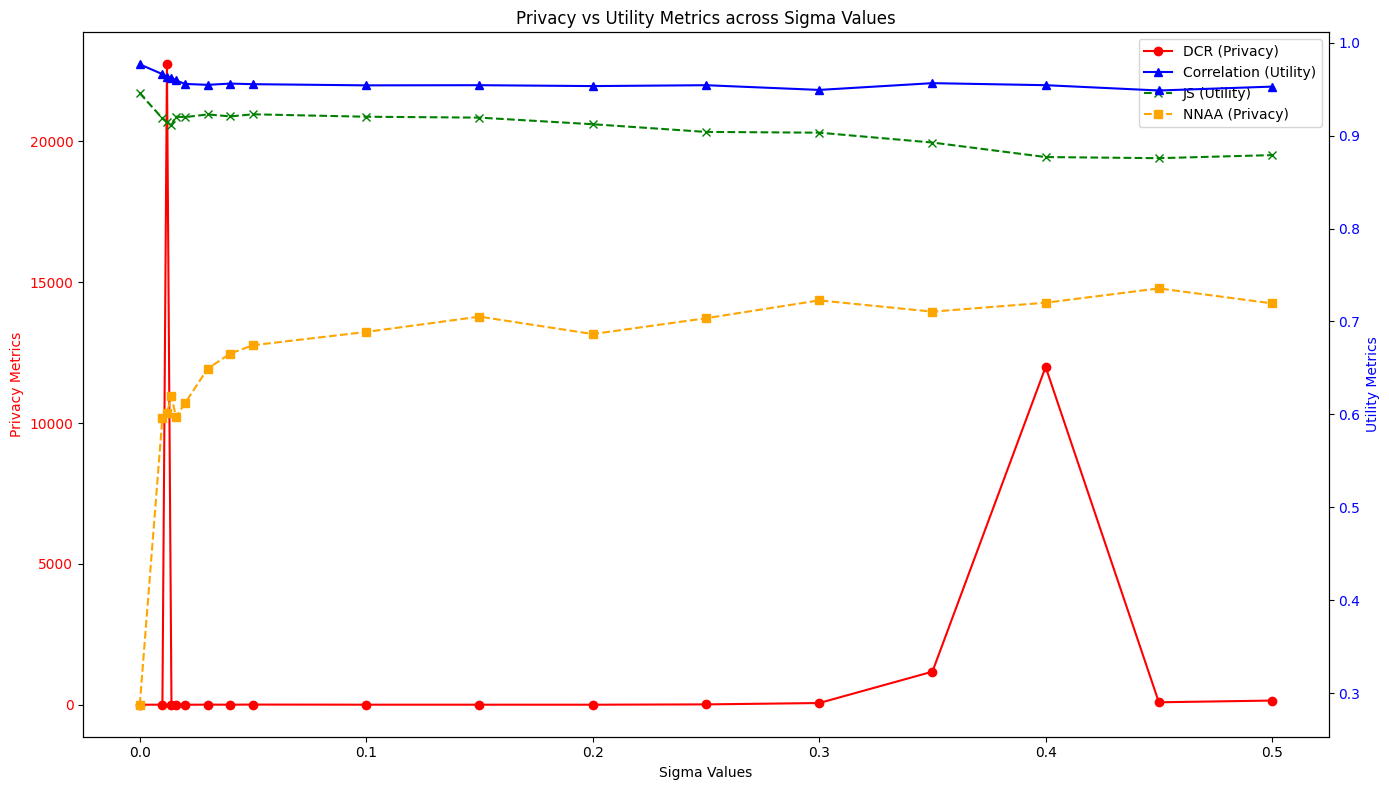

In [11]:
import matplotlib.pyplot as plt

datasets = df["sigma"]

DCR = df["DCR"]
adversarial_accuracy = df["NNAA"]

correlation = df["Correlation"]
JS = df["JS"]

fig, ax1 = plt.subplots(figsize=(14, 8))

ax1.plot(datasets, DCR, marker='o', color='red', label="DCR (Privacy)", linestyle='-')
ax1.set_xlabel("Sigma Values")
ax1.set_ylabel("Privacy Metrics", color='red')
ax1.tick_params(axis='y', labelcolor='red')

ax2 = ax1.twinx()
ax2.plot(datasets, correlation, marker='^', color='blue', label="Correlation (Utility)", linestyle='-')
ax2.plot(datasets, JS, marker='x', color='green', label="JS (Utility)", linestyle='--')
ax2.plot(datasets, adversarial_accuracy, marker='s', color='orange', label="NNAA (Privacy)", linestyle='--')
ax2.set_ylabel("Utility Metrics", color='blue')
ax2.tick_params(axis='y', labelcolor='blue')

lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc='upper right')

plt.title("Privacy vs Utility Metrics across Sigma Values")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### Replace

In [12]:
import os
import re
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict
from sklearn.preprocessing import MinMaxScaler
from privacy_utility_framework.privacy_utility_framework.metrics.utility_metrics.utility_metric_manager import UtilityMetricManager
from privacy_utility_framework.privacy_utility_framework.metrics.utility_metrics.statistical.basic_stats import BasicStatsCalculator
from privacy_utility_framework.privacy_utility_framework.metrics.utility_metrics.statistical.mutual_information import MICalculator
from privacy_utility_framework.privacy_utility_framework.metrics.utility_metrics.statistical.correlation import CorrelationCalculator
from privacy_utility_framework.privacy_utility_framework.metrics.utility_metrics.statistical.js_similarity import JSCalculator
from privacy_utility_framework.privacy_utility_framework.metrics.privacy_metrics.privacy_metric_manager import PrivacyMetricManager
from privacy_utility_framework.privacy_utility_framework.metrics.privacy_metrics.distance.adversarial_accuracy_class import AdversarialAccuracyCalculator, AdversarialAccuracyCalculator_NN
from privacy_utility_framework.privacy_utility_framework.metrics.privacy_metrics.distance.dcr_class import DCRCalculator
from privacy_utility_framework.privacy_utility_framework.metrics.privacy_metrics.distance.nndr_class import NNDRCalculator
from privacy_utility_framework.privacy_utility_framework.metrics.privacy_metrics.distance.disco import DisclosureCalculator

# Load original dataset
original_data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Tabula-main-claude/Real_Datasets/Insurance_compressed.csv")
original_name = "Insurance"

# Directory containing synthetic datasets
synthetic_folder = "/content/drive/MyDrive/Colab Notebooks/Tabula-main-claude/insurance_syn_data"

# Dictionary to store aggregated results
aggregated_results = defaultdict(lambda: defaultdict(list))

# Function to extract sigma value as float
def extract_sigma(file_name):
    match = re.search(r"sigma-(\d+)", file_name)
    if match:
        sigma_str = match.group(1)
        if len(sigma_str) == 1:  # Single digit like "1" -> "1"
            return int(sigma_str)
        elif len(sigma_str) == 2:  # Two digits like "05" -> "0.5"
            return int(sigma_str) / 10
        elif len(sigma_str) == 3:  # Three digits like "005" -> "0.05"
            return int(sigma_str) / 100
        elif len(sigma_str) == 4:  # Four digits like "0005" -> "0.005"
            return int(sigma_str) / 1000
    return None


# Loop through each synthetic file and perform calculations
for file_name in os.listdir(synthetic_folder):
    if file_name.endswith(".csv"):
        synthetic_path = os.path.join(synthetic_folder, file_name)
        synthetic_data = pd.read_csv(synthetic_path)
        synthetic_data = replace_outliers_with_mean(original_data, synthetic_data, file_name)
        # synthetic_data = remove_rows_with_outliers(original_data, synthetic_data, file_name)
        # Ensure correct data types (e.g., convert 'age' column to int if needed)
        for column in synthetic_data.columns:
            if column in original_data.columns:
                # Convert the column type in synthetic data to match the original data
                synthetic_data[column] = synthetic_data[column].astype(original_data[column].dtype)

        sigma = extract_sigma(file_name)
        if sigma is None:
            continue  # Skip files without a valid sigma value
        # print(f"\nProcessing synthetic dataset: {file_name} (sigma: {sigma})")

        # Utility Metric Calculation
        u = UtilityMetricManager()
        utility_metric_list = [
            BasicStatsCalculator(original_data, synthetic_data, original_name=original_name, synthetic_name=file_name),
            MICalculator(original_data, synthetic_data, original_name=original_name, synthetic_name=file_name),
            CorrelationCalculator(original_data, synthetic_data, original_name=original_name, synthetic_name=file_name),
            JSCalculator(original_data, synthetic_data, original_name=original_name, synthetic_name=file_name),
        ]
        u.add_metric(utility_metric_list)
        results_utility = u.evaluate_all()

        # Privacy Metric Calculation
        p = PrivacyMetricManager()
        privacy_metric_list = [
            DCRCalculator(original_data, synthetic_data, original_name=original_name, synthetic_name=file_name),
            NNDRCalculator(original_data, synthetic_data, original_name=original_name, synthetic_name=file_name),
            AdversarialAccuracyCalculator_NN(original_data, synthetic_data, original_name=original_name, synthetic_name=file_name),
            AdversarialAccuracyCalculator(original_data, synthetic_data, original_name=original_name, synthetic_name=file_name),
        ]
        p.add_metric(privacy_metric_list)
        results_privacy = p.evaluate_all()

        # # DiSCO and repU
        insurance_keys = ['age', 'bi', 'children']  # Adjust keys as per your dataset
        insurance_target = 'charges'
        calc = DisclosureCalculator(original_data, synthetic_data, keys=insurance_keys, target=insurance_target)
        repU, DiSCO = calc.evaluate()

        # Aggregate metrics
        for key, value in {**results_utility, **results_privacy}.items():
        # for key, value in {**results_utility}.items():
            aggregated_results[sigma][key].append(value)


        aggregated_results[sigma]["Disclosure_repU"].append(repU)
        aggregated_results[sigma]["Disclosure_DiSCO"].append(DiSCO)

# Calculate average metrics for each sigma
averaged_results = defaultdict(dict)
for sigma, metrics in aggregated_results.items():
    for metric, values in metrics.items():
        if isinstance(values[0], dict):
            averaged_results[sigma][metric] = {k: np.mean([v[k] for v in values]) for k in values[0]}
        else:
            averaged_results[sigma][metric] = np.mean(values)

Under insurance-sigma-000.csv total replacements made: 5
Method CorrelationMethod.PEARSON was used.


100%|██████████| 4/4 [00:00<00:00, 96.03it/s]


Synthetic and original data checked with synorig.compare,
 looks like no adjustment needed


-------------------Synthesis 1--------------------


/content/drive/MyDrive/Colab Notebooks/synprivutil-main/privacy_utility_framework/privacy_utility_framework/metrics/privacy_metrics/distance/disco.py:274: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  syndata[j][col] = syndata[j][col].astype('category')


Table for target charges from GT alone with keys has 1337 rows and 1328 columns.
Table for target charges from GT & SD with all key combinations has 1338 rows and 1778 columns.
IDENTITY: 
         UiO        UiS      UiOiS       repU
0  98.505232  63.356766  32.959641  21.449925
ATTRIBUTES: 
       Dorig       Dsyn         iS        DiS      DiSCO     DiSDiO  max_denom  mean_denom
0  98.654709  94.463972  33.856502  32.286996  29.745889  29.521674        1.0         1.0
~~~~~~~~~~~~~~~ Done ~~~~~~~~~~~~~~~
Under insurance-sigma-005.csv total replacements made: 11
Method CorrelationMethod.PEARSON was used.


100%|██████████| 4/4 [00:00<00:00, 84.93it/s]


Synthetic and original data checked with synorig.compare,
 looks like no adjustment needed


-------------------Synthesis 1--------------------


/content/drive/MyDrive/Colab Notebooks/synprivutil-main/privacy_utility_framework/privacy_utility_framework/metrics/privacy_metrics/distance/disco.py:274: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  syndata[j][col] = syndata[j][col].astype('category')


Table for target charges from GT alone with keys has 1337 rows and 1328 columns.
Table for target charges from GT & SD with all key combinations has 1338 rows and 2427 columns.
IDENTITY: 
         UiO        UiS     UiOiS      repU
0  98.505232  96.825397  1.270553  1.195815
ATTRIBUTES: 
       Dorig       Dsyn        iS       DiS  DiSCO  DiSDiO  max_denom  mean_denom
0  98.654709  96.825397  1.270553  1.195815    0.0     0.0        0.0         NaN
~~~~~~~~~~~~~~~ Done ~~~~~~~~~~~~~~~
Under insurance-sigma-010.csv total replacements made: 32
Method CorrelationMethod.PEARSON was used.


100%|██████████| 4/4 [00:00<00:00, 88.54it/s]


Synthetic and original data checked with synorig.compare,
 looks like no adjustment needed


-------------------Synthesis 1--------------------


/content/drive/MyDrive/Colab Notebooks/synprivutil-main/privacy_utility_framework/privacy_utility_framework/metrics/privacy_metrics/distance/disco.py:274: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  syndata[j][col] = syndata[j][col].astype('category')


Table for target charges from GT alone with keys has 1337 rows and 1328 columns.
Table for target charges from GT & SD with all key combinations has 1338 rows and 2405 columns.
IDENTITY: 
         UiO        UiS     UiOiS      repU
0  98.505232  95.803571  1.195815  1.046338
ATTRIBUTES: 
       Dorig       Dsyn        iS       DiS  DiSCO  DiSDiO  max_denom  mean_denom
0  98.654709  95.803571  1.494768  1.345291    0.0     0.0        0.0         NaN
~~~~~~~~~~~~~~~ Done ~~~~~~~~~~~~~~~
Under insurance-sigma-015.csv total replacements made: 38
Method CorrelationMethod.PEARSON was used.


100%|██████████| 4/4 [00:00<00:00, 89.00it/s]


Synthetic and original data checked with synorig.compare,
 looks like no adjustment needed


-------------------Synthesis 1--------------------


/content/drive/MyDrive/Colab Notebooks/synprivutil-main/privacy_utility_framework/privacy_utility_framework/metrics/privacy_metrics/distance/disco.py:274: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  syndata[j][col] = syndata[j][col].astype('category')


Table for target charges from GT alone with keys has 1337 rows and 1328 columns.
Table for target charges from GT & SD with all key combinations has 1338 rows and 2390 columns.
IDENTITY: 
         UiO        UiS     UiOiS      repU
0  98.505232  93.873874  0.747384  0.672646
ATTRIBUTES: 
       Dorig       Dsyn        iS       DiS  DiSCO  DiSDiO  max_denom  mean_denom
0  98.654709  93.873874  1.046338  0.971599    0.0     0.0        0.0         NaN
~~~~~~~~~~~~~~~ Done ~~~~~~~~~~~~~~~
Under insurance-sigma-020.csv total replacements made: 46
Method CorrelationMethod.PEARSON was used.


100%|██████████| 4/4 [00:00<00:00, 88.63it/s]


Synthetic and original data checked with synorig.compare,
 looks like no adjustment needed


-------------------Synthesis 1--------------------


/content/drive/MyDrive/Colab Notebooks/synprivutil-main/privacy_utility_framework/privacy_utility_framework/metrics/privacy_metrics/distance/disco.py:274: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  syndata[j][col] = syndata[j][col].astype('category')


Table for target charges from GT alone with keys has 1337 rows and 1328 columns.
Table for target charges from GT & SD with all key combinations has 1338 rows and 2395 columns.
IDENTITY: 
         UiO        UiS     UiOiS     repU
0  98.505232  94.404332  0.523169  0.44843
ATTRIBUTES: 
       Dorig       Dsyn        iS      DiS  DiSCO  DiSDiO  max_denom  mean_denom
0  98.654709  94.404332  0.523169  0.44843    0.0     0.0        0.0         NaN
~~~~~~~~~~~~~~~ Done ~~~~~~~~~~~~~~~
Under insurance-sigma-025.csv total replacements made: 82
Method CorrelationMethod.PEARSON was used.


100%|██████████| 4/4 [00:00<00:00, 84.81it/s]


Synthetic and original data checked with synorig.compare,
 looks like no adjustment needed


-------------------Synthesis 1--------------------


/content/drive/MyDrive/Colab Notebooks/synprivutil-main/privacy_utility_framework/privacy_utility_framework/metrics/privacy_metrics/distance/disco.py:274: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  syndata[j][col] = syndata[j][col].astype('category')


Table for target charges from GT alone with keys has 1337 rows and 1328 columns.
Table for target charges from GT & SD with all key combinations has 1338 rows and 2380 columns.
IDENTITY: 
         UiO        UiS     UiOiS      repU
0  98.505232  93.630573  0.672646  0.597907
ATTRIBUTES: 
       Dorig       Dsyn        iS       DiS  DiSCO  DiSDiO  max_denom  mean_denom
0  98.654709  93.630573  0.672646  0.597907    0.0     0.0        0.0         NaN
~~~~~~~~~~~~~~~ Done ~~~~~~~~~~~~~~~
Under insurance-sigma-030.csv total replacements made: 71
Method CorrelationMethod.PEARSON was used.


100%|██████████| 4/4 [00:00<00:00, 88.68it/s]


Synthetic and original data checked with synorig.compare,
 looks like no adjustment needed


-------------------Synthesis 1--------------------


/content/drive/MyDrive/Colab Notebooks/synprivutil-main/privacy_utility_framework/privacy_utility_framework/metrics/privacy_metrics/distance/disco.py:274: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  syndata[j][col] = syndata[j][col].astype('category')


Table for target charges from GT alone with keys has 1337 rows and 1328 columns.
Table for target charges from GT & SD with all key combinations has 1338 rows and 2342 columns.
IDENTITY: 
         UiO        UiS     UiOiS      repU
0  98.505232  89.953917  0.896861  0.896861
ATTRIBUTES: 
       Dorig       Dsyn        iS       DiS  DiSCO  DiSDiO  max_denom  mean_denom
0  98.654709  89.953917  0.896861  0.896861    0.0     0.0        0.0         NaN
~~~~~~~~~~~~~~~ Done ~~~~~~~~~~~~~~~
Under insurance-sigma-035.csv total replacements made: 105
Method CorrelationMethod.PEARSON was used.


100%|██████████| 4/4 [00:00<00:00, 90.89it/s]


Synthetic and original data checked with synorig.compare,
 looks like no adjustment needed


-------------------Synthesis 1--------------------


/content/drive/MyDrive/Colab Notebooks/synprivutil-main/privacy_utility_framework/privacy_utility_framework/metrics/privacy_metrics/distance/disco.py:274: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  syndata[j][col] = syndata[j][col].astype('category')


Table for target charges from GT alone with keys has 1337 rows and 1328 columns.
Table for target charges from GT & SD with all key combinations has 1338 rows and 2325 columns.
IDENTITY: 
         UiO        UiS     UiOiS      repU
0  98.505232  88.888889  0.672646  0.523169
ATTRIBUTES: 
       Dorig       Dsyn        iS       DiS  DiSCO  DiSDiO  max_denom  mean_denom
0  98.654709  88.888889  0.822123  0.523169    0.0     0.0        0.0         NaN
~~~~~~~~~~~~~~~ Done ~~~~~~~~~~~~~~~
Under insurance-sigma-040.csv total replacements made: 162
Method CorrelationMethod.PEARSON was used.


100%|██████████| 4/4 [00:00<00:00, 90.31it/s]


Synthetic and original data checked with synorig.compare,
 looks like no adjustment needed


-------------------Synthesis 1--------------------


/content/drive/MyDrive/Colab Notebooks/synprivutil-main/privacy_utility_framework/privacy_utility_framework/metrics/privacy_metrics/distance/disco.py:274: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  syndata[j][col] = syndata[j][col].astype('category')


Table for target charges from GT alone with keys has 1337 rows and 1328 columns.
Table for target charges from GT & SD with all key combinations has 1338 rows and 2284 columns.
IDENTITY: 
         UiO        UiS     UiOiS      repU
0  98.505232  85.876777  0.747384  0.672646
ATTRIBUTES: 
       Dorig       Dsyn        iS       DiS  DiSCO  DiSDiO  max_denom  mean_denom
0  98.654709  85.876777  0.896861  0.822123    0.0     0.0        0.0         NaN
~~~~~~~~~~~~~~~ Done ~~~~~~~~~~~~~~~
Under insurance-sigma-045.csv total replacements made: 158
Method CorrelationMethod.PEARSON was used.


100%|██████████| 4/4 [00:00<00:00, 90.57it/s]


Synthetic and original data checked with synorig.compare,
 looks like no adjustment needed


-------------------Synthesis 1--------------------


/content/drive/MyDrive/Colab Notebooks/synprivutil-main/privacy_utility_framework/privacy_utility_framework/metrics/privacy_metrics/distance/disco.py:274: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  syndata[j][col] = syndata[j][col].astype('category')


Table for target charges from GT alone with keys has 1337 rows and 1328 columns.
Table for target charges from GT & SD with all key combinations has 1338 rows and 2263 columns.
IDENTITY: 
         UiO        UiS     UiOiS      repU
0  98.505232  85.167464  0.747384  0.597907
ATTRIBUTES: 
       Dorig       Dsyn        iS       DiS  DiSCO  DiSDiO  max_denom  mean_denom
0  98.654709  85.167464  0.896861  0.747384    0.0     0.0        0.0         NaN
~~~~~~~~~~~~~~~ Done ~~~~~~~~~~~~~~~
Under insurance-sigma-050.csv total replacements made: 179
Method CorrelationMethod.PEARSON was used.


100%|██████████| 4/4 [00:00<00:00, 90.18it/s]


Synthetic and original data checked with synorig.compare,
 looks like no adjustment needed


-------------------Synthesis 1--------------------


/content/drive/MyDrive/Colab Notebooks/synprivutil-main/privacy_utility_framework/privacy_utility_framework/metrics/privacy_metrics/distance/disco.py:274: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  syndata[j][col] = syndata[j][col].astype('category')


Table for target charges from GT alone with keys has 1337 rows and 1328 columns.
Table for target charges from GT & SD with all key combinations has 1338 rows and 2248 columns.
IDENTITY: 
         UiO        UiS     UiOiS      repU
0  98.505232  84.960938  0.896861  0.747384
ATTRIBUTES: 
       Dorig       Dsyn        iS       DiS  DiSCO  DiSDiO  max_denom  mean_denom
0  98.654709  84.960938  1.046338  0.896861    0.0     0.0        0.0         NaN
~~~~~~~~~~~~~~~ Done ~~~~~~~~~~~~~~~
Under insurance-sigma-003.csv total replacements made: 15
Method CorrelationMethod.PEARSON was used.


100%|██████████| 4/4 [00:00<00:00, 91.52it/s]


Synthetic and original data checked with synorig.compare,
 looks like no adjustment needed


-------------------Synthesis 1--------------------


/content/drive/MyDrive/Colab Notebooks/synprivutil-main/privacy_utility_framework/privacy_utility_framework/metrics/privacy_metrics/distance/disco.py:274: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  syndata[j][col] = syndata[j][col].astype('category')


Table for target charges from GT alone with keys has 1337 rows and 1328 columns.
Table for target charges from GT & SD with all key combinations has 1338 rows and 2413 columns.
IDENTITY: 
         UiO        UiS     UiOiS      repU
0  98.505232  96.296296  1.943199  1.793722
ATTRIBUTES: 
       Dorig       Dsyn        iS       DiS  DiSCO  DiSDiO  max_denom  mean_denom
0  98.654709  96.296296  2.092676  1.943199    0.0     0.0        0.0         NaN
~~~~~~~~~~~~~~~ Done ~~~~~~~~~~~~~~~
Under insurance-sigma-004.csv total replacements made: 15
Method CorrelationMethod.PEARSON was used.


100%|██████████| 4/4 [00:00<00:00, 83.97it/s]


Synthetic and original data checked with synorig.compare,
 looks like no adjustment needed


-------------------Synthesis 1--------------------


/content/drive/MyDrive/Colab Notebooks/synprivutil-main/privacy_utility_framework/privacy_utility_framework/metrics/privacy_metrics/distance/disco.py:274: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  syndata[j][col] = syndata[j][col].astype('category')


Table for target charges from GT alone with keys has 1337 rows and 1328 columns.
Table for target charges from GT & SD with all key combinations has 1338 rows and 2408 columns.
IDENTITY: 
         UiO        UiS     UiOiS      repU
0  98.505232  96.355556  1.793722  1.644245
ATTRIBUTES: 
       Dorig       Dsyn        iS       DiS  DiSCO  DiSDiO  max_denom  mean_denom
0  98.654709  96.355556  1.793722  1.644245    0.0     0.0        0.0         NaN
~~~~~~~~~~~~~~~ Done ~~~~~~~~~~~~~~~
Under insurance-sigma-0016.csv total replacements made: 3
Method CorrelationMethod.PEARSON was used.


100%|██████████| 4/4 [00:00<00:00, 90.82it/s]


Synthetic and original data checked with synorig.compare,
 looks like no adjustment needed


-------------------Synthesis 1--------------------


/content/drive/MyDrive/Colab Notebooks/synprivutil-main/privacy_utility_framework/privacy_utility_framework/metrics/privacy_metrics/distance/disco.py:274: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  syndata[j][col] = syndata[j][col].astype('category')


Table for target charges from GT alone with keys has 1337 rows and 1328 columns.
Table for target charges from GT & SD with all key combinations has 1338 rows and 2408 columns.
IDENTITY: 
         UiO        UiS     UiOiS      repU
0  98.505232  96.466431  2.391629  2.316891
ATTRIBUTES: 
       Dorig       Dsyn        iS       DiS  DiSCO  DiSDiO  max_denom  mean_denom
0  98.654709  96.466431  2.391629  2.316891    0.0     0.0        0.0         NaN
~~~~~~~~~~~~~~~ Done ~~~~~~~~~~~~~~~
Under insurance-sigma-0014.csv total replacements made: 5
Method CorrelationMethod.PEARSON was used.


100%|██████████| 4/4 [00:00<00:00, 91.16it/s]


Synthetic and original data checked with synorig.compare,
 looks like no adjustment needed


-------------------Synthesis 1--------------------


/content/drive/MyDrive/Colab Notebooks/synprivutil-main/privacy_utility_framework/privacy_utility_framework/metrics/privacy_metrics/distance/disco.py:274: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  syndata[j][col] = syndata[j][col].astype('category')


Table for target charges from GT alone with keys has 1337 rows and 1328 columns.
Table for target charges from GT & SD with all key combinations has 1338 rows and 2398 columns.
IDENTITY: 
         UiO        UiS     UiOiS      repU
0  98.505232  94.885362  2.391629  2.391629
ATTRIBUTES: 
       Dorig       Dsyn       iS       DiS     DiSCO    DiSDiO  max_denom  mean_denom
0  98.654709  94.885362  2.84006  2.690583  0.149477  0.074738        1.0         1.0
~~~~~~~~~~~~~~~ Done ~~~~~~~~~~~~~~~
Under insurance-sigma-0010.csv total replacements made: 5
Method CorrelationMethod.PEARSON was used.


100%|██████████| 4/4 [00:00<00:00, 95.03it/s]


Synthetic and original data checked with synorig.compare,
 looks like no adjustment needed


-------------------Synthesis 1--------------------


/content/drive/MyDrive/Colab Notebooks/synprivutil-main/privacy_utility_framework/privacy_utility_framework/metrics/privacy_metrics/distance/disco.py:274: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  syndata[j][col] = syndata[j][col].astype('category')


Table for target charges from GT alone with keys has 1337 rows and 1328 columns.
Table for target charges from GT & SD with all key combinations has 1338 rows and 2371 columns.
IDENTITY: 
         UiO        UiS     UiOiS      repU
0  98.505232  94.522968  4.035874  3.587444
ATTRIBUTES: 
       Dorig       Dsyn        iS       DiS     DiSCO    DiSDiO  max_denom  mean_denom
0  98.654709  94.699647  4.484305  3.736921  0.896861  0.896861        1.0         1.0
~~~~~~~~~~~~~~~ Done ~~~~~~~~~~~~~~~
Under insurance-sigma-0012.csv total replacements made: 10
Method CorrelationMethod.PEARSON was used.


100%|██████████| 4/4 [00:00<00:00, 91.69it/s]


Synthetic and original data checked with synorig.compare,
 looks like no adjustment needed


-------------------Synthesis 1--------------------


/content/drive/MyDrive/Colab Notebooks/synprivutil-main/privacy_utility_framework/privacy_utility_framework/metrics/privacy_metrics/distance/disco.py:274: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  syndata[j][col] = syndata[j][col].astype('category')


Table for target charges from GT alone with keys has 1337 rows and 1328 columns.
Table for target charges from GT & SD with all key combinations has 1338 rows and 2386 columns.
IDENTITY: 
         UiO        UiS     UiOiS      repU
0  98.505232  95.510563  3.587444  3.139013
ATTRIBUTES: 
       Dorig      Dsyn        iS       DiS     DiSCO    DiSDiO  max_denom  mean_denom
0  98.654709  95.68662  4.185351  3.736921  0.298954  0.298954        1.0         1.0
~~~~~~~~~~~~~~~ Done ~~~~~~~~~~~~~~~
Under insurance-sigma-0020.csv total replacements made: 7
Method CorrelationMethod.PEARSON was used.


100%|██████████| 4/4 [00:00<00:00, 90.66it/s]


Synthetic and original data checked with synorig.compare,
 looks like no adjustment needed


-------------------Synthesis 1--------------------


/content/drive/MyDrive/Colab Notebooks/synprivutil-main/privacy_utility_framework/privacy_utility_framework/metrics/privacy_metrics/distance/disco.py:274: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  syndata[j][col] = syndata[j][col].astype('category')


Table for target charges from GT alone with keys has 1337 rows and 1328 columns.
Table for target charges from GT & SD with all key combinations has 1338 rows and 2408 columns.
IDENTITY: 
         UiO        UiS     UiOiS      repU
0  98.505232  96.819788  2.316891  2.167414
ATTRIBUTES: 
       Dorig       Dsyn        iS       DiS     DiSCO    DiSDiO  max_denom  mean_denom
0  98.654709  96.819788  2.765321  2.615845  0.149477  0.149477        1.0         1.0
~~~~~~~~~~~~~~~ Done ~~~~~~~~~~~~~~~


In [17]:
### replace
cleaned_results = defaultdict(dict)

for sigma, metrics in averaged_results.items():
    for metric, value in metrics.items():
        # Extract only the metric name, ignoring dataset/file info
        metric_name = metric.split("(")[0]
        if metric_name not in cleaned_results[sigma]:
            cleaned_results[sigma][metric_name] = []
        cleaned_results[sigma][metric_name].append(value)

# Aggregate and calculate average values for cleaned results
final_results = defaultdict(dict)
for sigma, metrics in cleaned_results.items():
    for metric, values in metrics.items():
        if isinstance(values[0], dict):  # If metric value is a dictionary
            # Average each key in the dictionary
            final_results[sigma][metric] = {k: sum(v[k] for v in values) / len(values) for k in values[0]}
        else:  # If metric value is a list of scalars
            final_results[sigma][metric] = sum(values) / len(values)

# Prepare data for plotting
data = {
    "sigma": sorted(final_results.keys()),
    "DCR": [final_results[sigma].get("DCRCalculator", None) for sigma in sorted(final_results.keys())],
    "NNDR": [final_results[sigma].get("NNDRCalculator", None) for sigma in sorted(final_results.keys())],
    # "AdversarialAccuracy": [final_results[sigma].get("AdversarialAccuracyCalculator", None) for sigma in sorted(final_results.keys())],
    "NNAA": [final_results[sigma].get("AdversarialAccuracyCalculator_NN", None) for sigma in sorted(final_results.keys())],
    "Correlation": [final_results[sigma].get("CorrelationCalculator", None) for sigma in sorted(final_results.keys())],
    "JS": [final_results[sigma].get("JSCalculator", None) for sigma in sorted(final_results.keys())],
    "repU": [final_results[sigma].get("Disclosure_repU", None) for sigma in sorted(final_results.keys())],
    "DiSCO": [final_results[sigma].get("Disclosure_DiSCO", None) for sigma in sorted(final_results.keys())],
}

# Convert to DataFrame
df = pd.DataFrame(data)

# Verify DataFrame content
print(df)


    sigma       DCR      NNDR      NNAA  Correlation        JS       repU      DiSCO
0   0.000  0.050441  0.336014  0.286476     0.985105  0.948761  21.449925  29.745889
1   0.010  0.141102  0.732895  0.598387     0.976812  0.919035   3.587444   0.896861
2   0.012  0.150779  0.747022  0.601147     0.965856  0.913455   3.139013   0.298954
3   0.014  0.156780  0.761400  0.619572     0.963605  0.909420   2.391629   0.149477
4   0.016  0.152955  0.757475  0.596415     0.961360  0.918417   2.316891   0.000000
5   0.020  0.150090  0.766770  0.610617     0.961153  0.918769   2.167414   0.149477
6   0.030  0.157812  0.778702  0.645908     0.957809  0.919764   1.793722   0.000000
7   0.040  0.165769  0.801643  0.663339     0.957961  0.920929   1.644245   0.000000
8   0.050  0.168793  0.796248  0.674024     0.956716  0.920821   1.195815   0.000000
9   0.100  0.173679  0.811626  0.685174     0.954608  0.923858   1.046338   0.000000
10  0.150  0.181631  0.816916  0.702977     0.954266  0.923954   

In [18]:
###
basic_stats_data = {
    "sigma": [],
    "mean": [],
    "median": [],
    "var": []
}

for sigma, metrics in final_results.items():
    if "BasicStatsCalculator" in metrics:
        basic_stats = metrics["BasicStatsCalculator"]
        basic_stats_data["sigma"].append(sigma)
        basic_stats_data["mean"].append(basic_stats["mean"])
        basic_stats_data["median"].append(basic_stats["median"])
        basic_stats_data["var"].append(basic_stats["var"])

basic_stats_df = pd.DataFrame(basic_stats_data)

print(basic_stats_df)


    sigma      mean    median       var
0   0.000  0.025308  0.049220  0.005338
1   0.050  0.035294  0.081194  0.008720
2   0.100  0.032926  0.044799  0.010064
3   0.150  0.030451  0.009137  0.011487
4   0.200  0.043567  0.043021  0.010252
5   0.250  0.044327  0.037329  0.011173
6   0.300  0.048571  0.045614  0.011062
7   0.350  0.052969  0.044490  0.011720
8   0.400  0.060878  0.043183  0.013442
9   0.450  0.067674  0.051640  0.012739
10  0.500  0.059600  0.040344  0.012172
11  0.030  0.026751  0.076389  0.009190
12  0.040  0.036709  0.080510  0.010505
13  0.016  0.030844  0.200059  0.010312
14  0.014  0.038934  0.057721  0.013452
15  0.010  0.039024  0.056381  0.012553
16  0.012  0.040150  0.059069  0.012622
17  0.020  0.027930  0.077684  0.008101


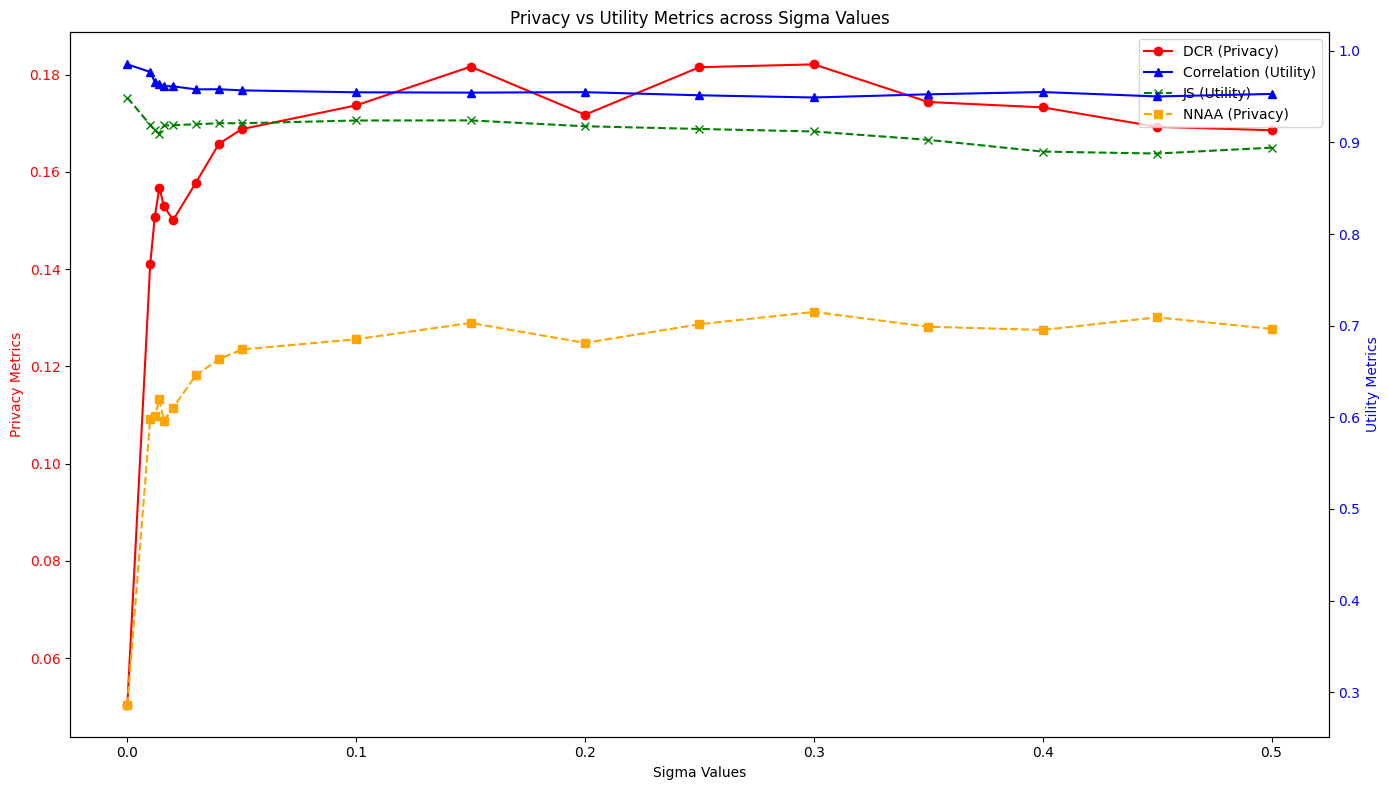

In [19]:
import matplotlib.pyplot as plt

datasets = df["sigma"]

DCR = df["DCR"]
adversarial_accuracy = df["NNAA"]

correlation = df["Correlation"]
JS = df["JS"]

fig, ax1 = plt.subplots(figsize=(14, 8))

ax1.plot(datasets, DCR, marker='o', color='red', label="DCR (Privacy)", linestyle='-')
ax1.set_xlabel("Sigma Values")
ax1.set_ylabel("Privacy Metrics", color='red')
ax1.tick_params(axis='y', labelcolor='red')

ax2 = ax1.twinx()
ax2.plot(datasets, correlation, marker='^', color='blue', label="Correlation (Utility)", linestyle='-')
ax2.plot(datasets, JS, marker='x', color='green', label="JS (Utility)", linestyle='--')
ax2.plot(datasets, adversarial_accuracy, marker='s', color='orange', label="NNAA (Privacy)", linestyle='--')
ax2.set_ylabel("Utility Metrics", color='blue')
ax2.tick_params(axis='y', labelcolor='blue')

lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc='upper right')

plt.title("Privacy vs Utility Metrics across Sigma Values")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### remove

In [20]:
import os
import re
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict
from sklearn.preprocessing import MinMaxScaler
from privacy_utility_framework.privacy_utility_framework.metrics.utility_metrics.utility_metric_manager import UtilityMetricManager
from privacy_utility_framework.privacy_utility_framework.metrics.utility_metrics.statistical.basic_stats import BasicStatsCalculator
from privacy_utility_framework.privacy_utility_framework.metrics.utility_metrics.statistical.mutual_information import MICalculator
from privacy_utility_framework.privacy_utility_framework.metrics.utility_metrics.statistical.correlation import CorrelationCalculator
from privacy_utility_framework.privacy_utility_framework.metrics.utility_metrics.statistical.js_similarity import JSCalculator
from privacy_utility_framework.privacy_utility_framework.metrics.privacy_metrics.privacy_metric_manager import PrivacyMetricManager
from privacy_utility_framework.privacy_utility_framework.metrics.privacy_metrics.distance.adversarial_accuracy_class import AdversarialAccuracyCalculator, AdversarialAccuracyCalculator_NN
from privacy_utility_framework.privacy_utility_framework.metrics.privacy_metrics.distance.dcr_class import DCRCalculator
from privacy_utility_framework.privacy_utility_framework.metrics.privacy_metrics.distance.nndr_class import NNDRCalculator
from privacy_utility_framework.privacy_utility_framework.metrics.privacy_metrics.distance.disco import DisclosureCalculator

# Load original dataset
original_data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Tabula-main-claude/Real_Datasets/Insurance_compressed.csv")
original_name = "Insurance"

# Directory containing synthetic datasets
synthetic_folder = "/content/drive/MyDrive/Colab Notebooks/Tabula-main-claude/insurance_syn_data"

# Dictionary to store aggregated results
aggregated_results = defaultdict(lambda: defaultdict(list))

# Function to extract sigma value as float
def extract_sigma(file_name):
    match = re.search(r"sigma-(\d+)", file_name)
    if match:
        sigma_str = match.group(1)
        if len(sigma_str) == 1:  # Single digit like "1" -> "1"
            return int(sigma_str)
        elif len(sigma_str) == 2:  # Two digits like "05" -> "0.5"
            return int(sigma_str) / 10
        elif len(sigma_str) == 3:  # Three digits like "005" -> "0.05"
            return int(sigma_str) / 100
        elif len(sigma_str) == 4:  # Four digits like "0005" -> "0.005"
            return int(sigma_str) / 1000
    return None


# Loop through each synthetic file and perform calculations
for file_name in os.listdir(synthetic_folder):
    if file_name.endswith(".csv"):
        synthetic_path = os.path.join(synthetic_folder, file_name)
        synthetic_data = pd.read_csv(synthetic_path)
        # synthetic_data = replace_outliers_with_mean(original_data, synthetic_data, file_name)
        synthetic_data = remove_rows_with_outliers(original_data, synthetic_data, file_name)
        # Ensure correct data types (e.g., convert 'age' column to int if needed)
        for column in synthetic_data.columns:
            if column in original_data.columns:
                # Convert the column type in synthetic data to match the original data
                synthetic_data[column] = synthetic_data[column].astype(original_data[column].dtype)

        sigma = extract_sigma(file_name)
        if sigma is None:
            continue  # Skip files without a valid sigma value
        # print(f"\nProcessing synthetic dataset: {file_name} (sigma: {sigma})")

        # Utility Metric Calculation
        u = UtilityMetricManager()
        utility_metric_list = [
            BasicStatsCalculator(original_data, synthetic_data, original_name=original_name, synthetic_name=file_name),
            MICalculator(original_data, synthetic_data, original_name=original_name, synthetic_name=file_name),
            CorrelationCalculator(original_data, synthetic_data, original_name=original_name, synthetic_name=file_name),
            JSCalculator(original_data, synthetic_data, original_name=original_name, synthetic_name=file_name),
        ]
        u.add_metric(utility_metric_list)
        results_utility = u.evaluate_all()

        # Privacy Metric Calculation
        p = PrivacyMetricManager()
        privacy_metric_list = [
            DCRCalculator(original_data, synthetic_data, original_name=original_name, synthetic_name=file_name),
            NNDRCalculator(original_data, synthetic_data, original_name=original_name, synthetic_name=file_name),
            AdversarialAccuracyCalculator_NN(original_data, synthetic_data, original_name=original_name, synthetic_name=file_name),
            AdversarialAccuracyCalculator(original_data, synthetic_data, original_name=original_name, synthetic_name=file_name),
        ]
        p.add_metric(privacy_metric_list)
        results_privacy = p.evaluate_all()

        # # DiSCO and repU
        insurance_keys = ['age', 'bi', 'children']  # Adjust keys as per your dataset
        insurance_target = 'charges'
        calc = DisclosureCalculator(original_data, synthetic_data, keys=insurance_keys, target=insurance_target)
        repU, DiSCO = calc.evaluate()

        # Aggregate metrics
        for key, value in {**results_utility, **results_privacy}.items():
        # for key, value in {**results_utility}.items():
            aggregated_results[sigma][key].append(value)


        aggregated_results[sigma]["Disclosure_repU"].append(repU)
        aggregated_results[sigma]["Disclosure_DiSCO"].append(DiSCO)

# Calculate average metrics for each sigma
averaged_results = defaultdict(dict)
for sigma, metrics in aggregated_results.items():
    for metric, values in metrics.items():
        if isinstance(values[0], dict):
            averaged_results[sigma][metric] = {k: np.mean([v[k] for v in values]) for k in values[0]}
        else:
            averaged_results[sigma][metric] = np.mean(values)

Under insurance-sigma-000.csv, removed 5 rows with outliers.
Method CorrelationMethod.PEARSON was used.


100%|██████████| 4/4 [00:00<00:00, 92.13it/s]


Synthetic and original data checked with synorig.compare,
 looks like no adjustment needed


-------------------Synthesis 1--------------------


/content/drive/MyDrive/Colab Notebooks/synprivutil-main/privacy_utility_framework/privacy_utility_framework/metrics/privacy_metrics/distance/disco.py:274: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  syndata[j][col] = syndata[j][col].astype('category')


Table for target charges from GT alone with keys has 1337 rows and 1328 columns.
Table for target charges from GT & SD with all key combinations has 1338 rows and 1774 columns.
IDENTITY: 
         UiO       UiS      UiOiS       repU
0  98.505232  63.37158  32.959641  21.449925
ATTRIBUTES: 
       Dorig       Dsyn         iS        DiS      DiSCO     DiSDiO  max_denom  mean_denom
0  98.654709  94.439541  33.856502  32.286996  29.745889  29.521674        1.0         1.0
~~~~~~~~~~~~~~~ Done ~~~~~~~~~~~~~~~
Under insurance-sigma-005.csv, removed 11 rows with outliers.
Method CorrelationMethod.PEARSON was used.


100%|██████████| 4/4 [00:00<00:00, 87.54it/s]


Synthetic and original data checked with synorig.compare,
 looks like no adjustment needed


-------------------Synthesis 1--------------------


/content/drive/MyDrive/Colab Notebooks/synprivutil-main/privacy_utility_framework/privacy_utility_framework/metrics/privacy_metrics/distance/disco.py:274: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  syndata[j][col] = syndata[j][col].astype('category')


Table for target charges from GT alone with keys has 1337 rows and 1328 columns.
Table for target charges from GT & SD with all key combinations has 1338 rows and 2416 columns.
IDENTITY: 
         UiO        UiS     UiOiS      repU
0  98.505232  96.794301  1.270553  1.195815
ATTRIBUTES: 
       Dorig       Dsyn        iS       DiS  DiSCO  DiSDiO  max_denom  mean_denom
0  98.654709  96.794301  1.270553  1.195815    0.0     0.0        0.0         NaN
~~~~~~~~~~~~~~~ Done ~~~~~~~~~~~~~~~
Under insurance-sigma-010.csv, removed 31 rows with outliers.
Method CorrelationMethod.PEARSON was used.


100%|██████████| 4/4 [00:00<00:00, 91.95it/s]


Synthetic and original data checked with synorig.compare,
 looks like no adjustment needed


-------------------Synthesis 1--------------------


/content/drive/MyDrive/Colab Notebooks/synprivutil-main/privacy_utility_framework/privacy_utility_framework/metrics/privacy_metrics/distance/disco.py:274: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  syndata[j][col] = syndata[j][col].astype('category')


Table for target charges from GT alone with keys has 1337 rows and 1328 columns.
Table for target charges from GT & SD with all key combinations has 1338 rows and 2380 columns.
IDENTITY: 
         UiO       UiS     UiOiS      repU
0  98.505232  96.51056  1.195815  1.121076
ATTRIBUTES: 
       Dorig      Dsyn        iS       DiS  DiSCO  DiSDiO  max_denom  mean_denom
0  98.654709  96.51056  1.345291  1.270553    0.0     0.0        0.0         NaN
~~~~~~~~~~~~~~~ Done ~~~~~~~~~~~~~~~
Under insurance-sigma-015.csv, removed 38 rows with outliers.
Method CorrelationMethod.PEARSON was used.


100%|██████████| 4/4 [00:00<00:00, 88.62it/s]


Synthetic and original data checked with synorig.compare,
 looks like no adjustment needed


-------------------Synthesis 1--------------------


/content/drive/MyDrive/Colab Notebooks/synprivutil-main/privacy_utility_framework/privacy_utility_framework/metrics/privacy_metrics/distance/disco.py:274: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  syndata[j][col] = syndata[j][col].astype('category')


Table for target charges from GT alone with keys has 1337 rows and 1328 columns.
Table for target charges from GT & SD with all key combinations has 1338 rows and 2360 columns.
IDENTITY: 
         UiO        UiS     UiOiS      repU
0  98.505232  94.776119  0.747384  0.747384
ATTRIBUTES: 
       Dorig       Dsyn        iS       DiS  DiSCO  DiSDiO  max_denom  mean_denom
0  98.654709  94.776119  0.896861  0.896861    0.0     0.0        0.0         NaN
~~~~~~~~~~~~~~~ Done ~~~~~~~~~~~~~~~
Under insurance-sigma-020.csv, removed 46 rows with outliers.
Method CorrelationMethod.PEARSON was used.


100%|██████████| 4/4 [00:00<00:00, 89.98it/s]


Synthetic and original data checked with synorig.compare,
 looks like no adjustment needed


-------------------Synthesis 1--------------------


/content/drive/MyDrive/Colab Notebooks/synprivutil-main/privacy_utility_framework/privacy_utility_framework/metrics/privacy_metrics/distance/disco.py:274: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  syndata[j][col] = syndata[j][col].astype('category')


Table for target charges from GT alone with keys has 1337 rows and 1328 columns.
Table for target charges from GT & SD with all key combinations has 1338 rows and 2362 columns.
IDENTITY: 
         UiO        UiS    UiOiS     repU
0  98.505232  96.045198  0.44843  0.44843
ATTRIBUTES: 
       Dorig       Dsyn       iS      DiS  DiSCO  DiSDiO  max_denom  mean_denom
0  98.654709  96.045198  0.44843  0.44843    0.0     0.0        0.0         NaN
~~~~~~~~~~~~~~~ Done ~~~~~~~~~~~~~~~
Under insurance-sigma-025.csv, removed 82 rows with outliers.
Method CorrelationMethod.PEARSON was used.


100%|██████████| 4/4 [00:00<00:00, 92.05it/s]


Synthetic and original data checked with synorig.compare,
 looks like no adjustment needed


-------------------Synthesis 1--------------------


/content/drive/MyDrive/Colab Notebooks/synprivutil-main/privacy_utility_framework/privacy_utility_framework/metrics/privacy_metrics/distance/disco.py:274: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  syndata[j][col] = syndata[j][col].astype('category')


Table for target charges from GT alone with keys has 1337 rows and 1328 columns.
Table for target charges from GT & SD with all key combinations has 1338 rows and 2316 columns.
IDENTITY: 
         UiO        UiS     UiOiS      repU
0  98.505232  95.870206  0.597907  0.597907
ATTRIBUTES: 
       Dorig       Dsyn        iS       DiS  DiSCO  DiSDiO  max_denom  mean_denom
0  98.654709  95.870206  0.597907  0.597907    0.0     0.0        0.0         NaN
~~~~~~~~~~~~~~~ Done ~~~~~~~~~~~~~~~
Under insurance-sigma-030.csv, removed 69 rows with outliers.
Method CorrelationMethod.PEARSON was used.


100%|██████████| 4/4 [00:00<00:00, 95.14it/s]


Synthetic and original data checked with synorig.compare,
 looks like no adjustment needed


-------------------Synthesis 1--------------------


/content/drive/MyDrive/Colab Notebooks/synprivutil-main/privacy_utility_framework/privacy_utility_framework/metrics/privacy_metrics/distance/disco.py:274: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  syndata[j][col] = syndata[j][col].astype('category')


Table for target charges from GT alone with keys has 1337 rows and 1328 columns.
Table for target charges from GT & SD with all key combinations has 1338 rows and 2288 columns.
IDENTITY: 
         UiO        UiS     UiOiS      repU
0  98.505232  91.830709  0.822123  0.822123
ATTRIBUTES: 
       Dorig       Dsyn        iS       DiS  DiSCO  DiSDiO  max_denom  mean_denom
0  98.654709  91.830709  0.822123  0.822123    0.0     0.0        0.0         NaN
~~~~~~~~~~~~~~~ Done ~~~~~~~~~~~~~~~
Under insurance-sigma-035.csv, removed 102 rows with outliers.
Method CorrelationMethod.PEARSON was used.


100%|██████████| 4/4 [00:00<00:00, 94.07it/s]


Synthetic and original data checked with synorig.compare,
 looks like no adjustment needed


-------------------Synthesis 1--------------------


/content/drive/MyDrive/Colab Notebooks/synprivutil-main/privacy_utility_framework/privacy_utility_framework/metrics/privacy_metrics/distance/disco.py:274: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  syndata[j][col] = syndata[j][col].astype('category')


Table for target charges from GT alone with keys has 1337 rows and 1328 columns.
Table for target charges from GT & SD with all key combinations has 1338 rows and 2256 columns.
IDENTITY: 
         UiO        UiS     UiOiS     repU
0  98.505232  93.292054  0.523169  0.44843
ATTRIBUTES: 
       Dorig       Dsyn        iS      DiS  DiSCO  DiSDiO  max_denom  mean_denom
0  98.654709  93.292054  0.523169  0.44843    0.0     0.0        0.0         NaN
~~~~~~~~~~~~~~~ Done ~~~~~~~~~~~~~~~
Under insurance-sigma-040.csv, removed 158 rows with outliers.
Method CorrelationMethod.PEARSON was used.


100%|██████████| 4/4 [00:00<00:00, 100.97it/s]


Synthetic and original data checked with synorig.compare,
 looks like no adjustment needed


-------------------Synthesis 1--------------------


/content/drive/MyDrive/Colab Notebooks/synprivutil-main/privacy_utility_framework/privacy_utility_framework/metrics/privacy_metrics/distance/disco.py:274: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  syndata[j][col] = syndata[j][col].astype('category')


Table for target charges from GT alone with keys has 1337 rows and 1328 columns.
Table for target charges from GT & SD with all key combinations has 1338 rows and 2189 columns.
IDENTITY: 
         UiO        UiS     UiOiS      repU
0  98.505232  94.202899  0.597907  0.523169
ATTRIBUTES: 
       Dorig       Dsyn        iS       DiS  DiSCO  DiSDiO  max_denom  mean_denom
0  98.654709  94.202899  0.597907  0.523169    0.0     0.0        0.0         NaN
~~~~~~~~~~~~~~~ Done ~~~~~~~~~~~~~~~
Under insurance-sigma-045.csv, removed 155 rows with outliers.
Method CorrelationMethod.PEARSON was used.


100%|██████████| 4/4 [00:00<00:00, 97.36it/s]


Synthetic and original data checked with synorig.compare,
 looks like no adjustment needed


-------------------Synthesis 1--------------------


/content/drive/MyDrive/Colab Notebooks/synprivutil-main/privacy_utility_framework/privacy_utility_framework/metrics/privacy_metrics/distance/disco.py:274: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  syndata[j][col] = syndata[j][col].astype('category')


Table for target charges from GT alone with keys has 1337 rows and 1328 columns.
Table for target charges from GT & SD with all key combinations has 1338 rows and 2174 columns.
IDENTITY: 
         UiO        UiS     UiOiS      repU
0  98.505232  92.696629  0.597907  0.523169
ATTRIBUTES: 
       Dorig       Dsyn        iS       DiS  DiSCO  DiSDiO  max_denom  mean_denom
0  98.654709  92.696629  0.597907  0.523169    0.0     0.0        0.0         NaN
~~~~~~~~~~~~~~~ Done ~~~~~~~~~~~~~~~
Under insurance-sigma-050.csv, removed 169 rows with outliers.
Method CorrelationMethod.PEARSON was used.


100%|██████████| 4/4 [00:00<00:00, 102.92it/s]


Synthetic and original data checked with synorig.compare,
 looks like no adjustment needed


-------------------Synthesis 1--------------------


/content/drive/MyDrive/Colab Notebooks/synprivutil-main/privacy_utility_framework/privacy_utility_framework/metrics/privacy_metrics/distance/disco.py:274: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  syndata[j][col] = syndata[j][col].astype('category')


Table for target charges from GT alone with keys has 1337 rows and 1328 columns.
Table for target charges from GT & SD with all key combinations has 1338 rows and 2147 columns.
IDENTITY: 
         UiO        UiS     UiOiS      repU
0  98.505232  93.918129  0.672646  0.597907
ATTRIBUTES: 
       Dorig       Dsyn        iS       DiS  DiSCO  DiSDiO  max_denom  mean_denom
0  98.654709  93.918129  0.672646  0.597907    0.0     0.0        0.0         NaN
~~~~~~~~~~~~~~~ Done ~~~~~~~~~~~~~~~
Under insurance-sigma-003.csv, removed 15 rows with outliers.
Method CorrelationMethod.PEARSON was used.


100%|██████████| 4/4 [00:00<00:00, 90.58it/s]


Synthetic and original data checked with synorig.compare,
 looks like no adjustment needed


-------------------Synthesis 1--------------------


/content/drive/MyDrive/Colab Notebooks/synprivutil-main/privacy_utility_framework/privacy_utility_framework/metrics/privacy_metrics/distance/disco.py:274: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  syndata[j][col] = syndata[j][col].astype('category')


Table for target charges from GT alone with keys has 1337 rows and 1328 columns.
Table for target charges from GT & SD with all key combinations has 1338 rows and 2398 columns.
IDENTITY: 
         UiO        UiS     UiOiS      repU
0  98.505232  96.246649  1.943199  1.793722
ATTRIBUTES: 
       Dorig       Dsyn        iS       DiS  DiSCO  DiSDiO  max_denom  mean_denom
0  98.654709  96.246649  2.092676  1.943199    0.0     0.0        0.0         NaN
~~~~~~~~~~~~~~~ Done ~~~~~~~~~~~~~~~
Under insurance-sigma-004.csv, removed 15 rows with outliers.
Method CorrelationMethod.PEARSON was used.


100%|██████████| 4/4 [00:00<00:00, 87.21it/s]


Synthetic and original data checked with synorig.compare,
 looks like no adjustment needed


-------------------Synthesis 1--------------------


/content/drive/MyDrive/Colab Notebooks/synprivutil-main/privacy_utility_framework/privacy_utility_framework/metrics/privacy_metrics/distance/disco.py:274: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  syndata[j][col] = syndata[j][col].astype('category')


Table for target charges from GT alone with keys has 1337 rows and 1328 columns.
Table for target charges from GT & SD with all key combinations has 1338 rows and 2393 columns.
IDENTITY: 
         UiO        UiS     UiOiS      repU
0  98.505232  96.306306  1.793722  1.644245
ATTRIBUTES: 
       Dorig       Dsyn        iS       DiS  DiSCO  DiSDiO  max_denom  mean_denom
0  98.654709  96.306306  1.793722  1.644245    0.0     0.0        0.0         NaN
~~~~~~~~~~~~~~~ Done ~~~~~~~~~~~~~~~
Under insurance-sigma-0016.csv, removed 3 rows with outliers.
Method CorrelationMethod.PEARSON was used.


100%|██████████| 4/4 [00:00<00:00, 89.08it/s]


Synthetic and original data checked with synorig.compare,
 looks like no adjustment needed


-------------------Synthesis 1--------------------


/content/drive/MyDrive/Colab Notebooks/synprivutil-main/privacy_utility_framework/privacy_utility_framework/metrics/privacy_metrics/distance/disco.py:274: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  syndata[j][col] = syndata[j][col].astype('category')


Table for target charges from GT alone with keys has 1337 rows and 1328 columns.
Table for target charges from GT & SD with all key combinations has 1338 rows and 2405 columns.
IDENTITY: 
         UiO        UiS     UiOiS      repU
0  98.505232  96.457042  2.391629  2.316891
ATTRIBUTES: 
       Dorig       Dsyn        iS       DiS  DiSCO  DiSDiO  max_denom  mean_denom
0  98.654709  96.457042  2.391629  2.316891    0.0     0.0        0.0         NaN
~~~~~~~~~~~~~~~ Done ~~~~~~~~~~~~~~~
Under insurance-sigma-0014.csv, removed 5 rows with outliers.
Method CorrelationMethod.PEARSON was used.


100%|██████████| 4/4 [00:00<00:00, 90.02it/s]


Synthetic and original data checked with synorig.compare,
 looks like no adjustment needed


-------------------Synthesis 1--------------------


/content/drive/MyDrive/Colab Notebooks/synprivutil-main/privacy_utility_framework/privacy_utility_framework/metrics/privacy_metrics/distance/disco.py:274: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  syndata[j][col] = syndata[j][col].astype('category')


Table for target charges from GT alone with keys has 1337 rows and 1328 columns.
Table for target charges from GT & SD with all key combinations has 1338 rows and 2394 columns.
IDENTITY: 
         UiO        UiS     UiOiS      repU
0  98.505232  95.039858  2.391629  2.391629
ATTRIBUTES: 
       Dorig       Dsyn       iS       DiS     DiSCO    DiSDiO  max_denom  mean_denom
0  98.654709  95.039858  2.84006  2.690583  0.149477  0.074738        1.0         1.0
~~~~~~~~~~~~~~~ Done ~~~~~~~~~~~~~~~
Under insurance-sigma-0010.csv, removed 5 rows with outliers.
Method CorrelationMethod.PEARSON was used.


100%|██████████| 4/4 [00:00<00:00, 90.58it/s]


Synthetic and original data checked with synorig.compare,
 looks like no adjustment needed


-------------------Synthesis 1--------------------


/content/drive/MyDrive/Colab Notebooks/synprivutil-main/privacy_utility_framework/privacy_utility_framework/metrics/privacy_metrics/distance/disco.py:274: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  syndata[j][col] = syndata[j][col].astype('category')


Table for target charges from GT alone with keys has 1337 rows and 1328 columns.
Table for target charges from GT & SD with all key combinations has 1338 rows and 2366 columns.
IDENTITY: 
         UiO        UiS     UiOiS      repU
0  98.505232  94.498669  4.035874  3.587444
ATTRIBUTES: 
       Dorig       Dsyn        iS       DiS     DiSCO    DiSDiO  max_denom  mean_denom
0  98.654709  94.676131  4.484305  3.736921  0.896861  0.896861        1.0         1.0
~~~~~~~~~~~~~~~ Done ~~~~~~~~~~~~~~~
Under insurance-sigma-0012.csv, removed 10 rows with outliers.
Method CorrelationMethod.PEARSON was used.


100%|██████████| 4/4 [00:00<00:00, 90.87it/s]


Synthetic and original data checked with synorig.compare,
 looks like no adjustment needed


-------------------Synthesis 1--------------------


/content/drive/MyDrive/Colab Notebooks/synprivutil-main/privacy_utility_framework/privacy_utility_framework/metrics/privacy_metrics/distance/disco.py:274: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  syndata[j][col] = syndata[j][col].astype('category')


Table for target charges from GT alone with keys has 1337 rows and 1328 columns.
Table for target charges from GT & SD with all key combinations has 1338 rows and 2377 columns.
IDENTITY: 
         UiO        UiS     UiOiS      repU
0  98.505232  95.470693  3.512706  3.064275
ATTRIBUTES: 
       Dorig       Dsyn        iS       DiS     DiSCO    DiSDiO  max_denom  mean_denom
0  98.654709  95.648313  4.110613  3.662182  0.298954  0.298954        1.0         1.0
~~~~~~~~~~~~~~~ Done ~~~~~~~~~~~~~~~
Under insurance-sigma-0020.csv, removed 6 rows with outliers.
Method CorrelationMethod.PEARSON was used.


100%|██████████| 4/4 [00:00<00:00, 89.41it/s]


Synthetic and original data checked with synorig.compare,
 looks like no adjustment needed


-------------------Synthesis 1--------------------


/content/drive/MyDrive/Colab Notebooks/synprivutil-main/privacy_utility_framework/privacy_utility_framework/metrics/privacy_metrics/distance/disco.py:274: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  syndata[j][col] = syndata[j][col].astype('category')


Table for target charges from GT alone with keys has 1337 rows and 1328 columns.
Table for target charges from GT & SD with all key combinations has 1338 rows and 2402 columns.
IDENTITY: 
         UiO        UiS     UiOiS      repU
0  98.505232  96.802842  2.316891  2.167414
ATTRIBUTES: 
       Dorig       Dsyn        iS       DiS     DiSCO    DiSDiO  max_denom  mean_denom
0  98.654709  96.802842  2.765321  2.615845  0.149477  0.149477        1.0         1.0
~~~~~~~~~~~~~~~ Done ~~~~~~~~~~~~~~~


In [21]:
### remove
cleaned_results = defaultdict(dict)

for sigma, metrics in averaged_results.items():
    for metric, value in metrics.items():
        # Extract only the metric name, ignoring dataset/file info
        metric_name = metric.split("(")[0]
        if metric_name not in cleaned_results[sigma]:
            cleaned_results[sigma][metric_name] = []
        cleaned_results[sigma][metric_name].append(value)

# Aggregate and calculate average values for cleaned results
final_results = defaultdict(dict)
for sigma, metrics in cleaned_results.items():
    for metric, values in metrics.items():
        if isinstance(values[0], dict):  # If metric value is a dictionary
            # Average each key in the dictionary
            final_results[sigma][metric] = {k: sum(v[k] for v in values) / len(values) for k in values[0]}
        else:  # If metric value is a list of scalars
            final_results[sigma][metric] = sum(values) / len(values)

# Prepare data for plotting
data = {
    "sigma": sorted(final_results.keys()),
    "DCR": [final_results[sigma].get("DCRCalculator", None) for sigma in sorted(final_results.keys())],
    "NNDR": [final_results[sigma].get("NNDRCalculator", None) for sigma in sorted(final_results.keys())],
    # "AdversarialAccuracy": [final_results[sigma].get("AdversarialAccuracyCalculator", None) for sigma in sorted(final_results.keys())],
    "NNAA": [final_results[sigma].get("AdversarialAccuracyCalculator_NN", None) for sigma in sorted(final_results.keys())],
    "Correlation": [final_results[sigma].get("CorrelationCalculator", None) for sigma in sorted(final_results.keys())],
    "JS": [final_results[sigma].get("JSCalculator", None) for sigma in sorted(final_results.keys())],
    "repU": [final_results[sigma].get("Disclosure_repU", None) for sigma in sorted(final_results.keys())],
    "DiSCO": [final_results[sigma].get("Disclosure_DiSCO", None) for sigma in sorted(final_results.keys())],
}

# Convert to DataFrame
df = pd.DataFrame(data)

# Verify DataFrame content
print(df)


    sigma       DCR      NNDR      NNAA  Correlation        JS       repU      DiSCO
0   0.000  0.050264  0.334731  0.286756     0.985186  0.948864  21.449925  29.745889
1   0.010  0.140906  0.732202  0.596512     0.976625  0.919546   3.587444   0.896861
2   0.012  0.150724  0.746764  0.599535     0.965709  0.913915   3.064275   0.298954
3   0.014  0.156322  0.761200  0.618584     0.963649  0.909660   2.391629   0.149477
4   0.016  0.153007  0.757486  0.596924     0.961338  0.918423   2.316891   0.000000
5   0.020  0.149814  0.766723  0.611520     0.960993  0.919172   2.167414   0.149477
6   0.030  0.158291  0.779012  0.647379     0.957876  0.920179   1.793722   0.000000
7   0.040  0.166400  0.802334  0.665000     0.958076  0.921368   1.644245   0.000000
8   0.050  0.169017  0.796021  0.672517     0.956709  0.921339   1.195815   0.000000
9   0.100  0.173680  0.811372  0.686492     0.954753  0.923810   1.121076   0.000000
10  0.150  0.181723  0.818431  0.700957     0.954172  0.924887   

In [22]:
###
basic_stats_data = {
    "sigma": [],
    "mean": [],
    "median": [],
    "var": []
}

for sigma, metrics in final_results.items():
    if "BasicStatsCalculator" in metrics:
        basic_stats = metrics["BasicStatsCalculator"]
        basic_stats_data["sigma"].append(sigma)
        basic_stats_data["mean"].append(basic_stats["mean"])
        basic_stats_data["median"].append(basic_stats["median"])
        basic_stats_data["var"].append(basic_stats["var"])

basic_stats_df = pd.DataFrame(basic_stats_data)

print(basic_stats_df)


    sigma      mean    median       var
0   0.000  0.025901  0.049390  0.005262
1   0.050  0.034949  0.081191  0.008678
2   0.100  0.033931  0.045199  0.010094
3   0.150  0.030722  0.010290  0.011340
4   0.200  0.042149  0.044032  0.010009
5   0.250  0.043693  0.042648  0.010700
6   0.300  0.048968  0.046828  0.011954
7   0.350  0.053789  0.050241  0.011874
8   0.400  0.062871  0.052469  0.013732
9   0.450  0.066153  0.057908  0.011630
10  0.500  0.059491  0.047644  0.011794
11  0.030  0.026633  0.076770  0.009207
12  0.040  0.036481  0.080503  0.010465
13  0.016  0.030966  0.200058  0.010348
14  0.014  0.038514  0.057665  0.013256
15  0.010  0.038671  0.056506  0.012431
16  0.012  0.040233  0.059068  0.012580
17  0.020  0.027681  0.077684  0.007912


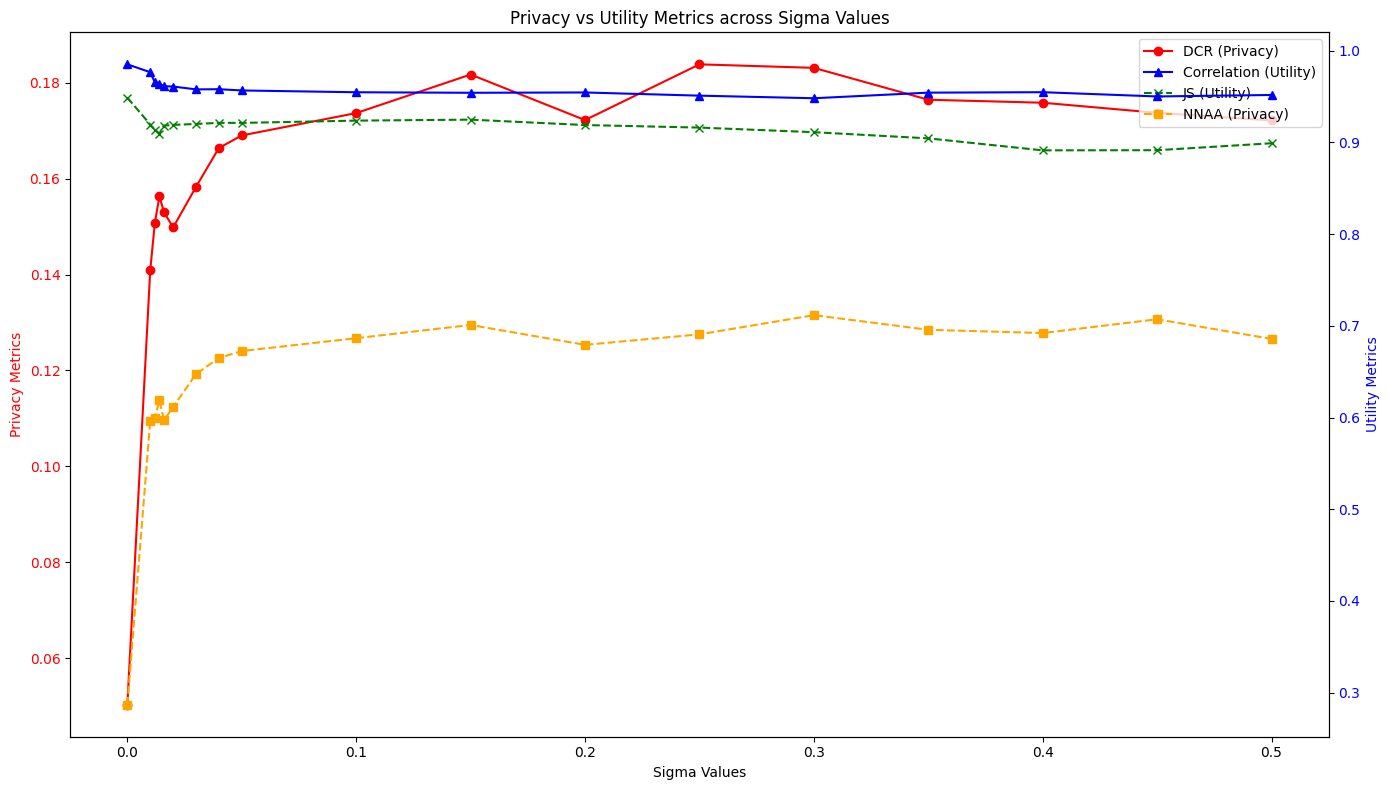

In [23]:
import matplotlib.pyplot as plt

datasets = df["sigma"]

DCR = df["DCR"]
adversarial_accuracy = df["NNAA"]

correlation = df["Correlation"]
JS = df["JS"]

fig, ax1 = plt.subplots(figsize=(14, 8))

ax1.plot(datasets, DCR, marker='o', color='red', label="DCR (Privacy)", linestyle='-')
ax1.set_xlabel("Sigma Values")
ax1.set_ylabel("Privacy Metrics", color='red')
ax1.tick_params(axis='y', labelcolor='red')

ax2 = ax1.twinx()
ax2.plot(datasets, correlation, marker='^', color='blue', label="Correlation (Utility)", linestyle='-')
ax2.plot(datasets, JS, marker='x', color='green', label="JS (Utility)", linestyle='--')
ax2.plot(datasets, adversarial_accuracy, marker='s', color='orange', label="NNAA (Privacy)", linestyle='--')
ax2.set_ylabel("Utility Metrics", color='blue')
ax2.tick_params(axis='y', labelcolor='blue')

lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc='upper right')

plt.title("Privacy vs Utility Metrics across Sigma Values")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## Comparison

Under insurance-sigma-000.csv, removed 5 rows with outliers.
Under insurance-sigma-003.csv, removed 15 rows with outliers.
Under insurance-sigma-004.csv, removed 15 rows with outliers.


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

Under insurance-sigma-005.csv, removed 11 rows with outliers.
Under insurance-sigma-010.csv, removed 31 rows with outliers.
Under insurance-sigma-015.csv, removed 38 rows with outliers.
Under insurance-sigma-020.csv, removed 46 rows with outliers.


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

Under insurance-sigma-025.csv, removed 82 rows with outliers.
Under insurance-sigma-030.csv, removed 69 rows with outliers.
Under insurance-sigma-035.csv, removed 102 rows with outliers.
Under insurance-sigma-040.csv, removed 158 rows with outliers.


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

Under insurance-sigma-045.csv, removed 155 rows with outliers.
Under insurance-sigma-050.csv, removed 169 rows with outliers.


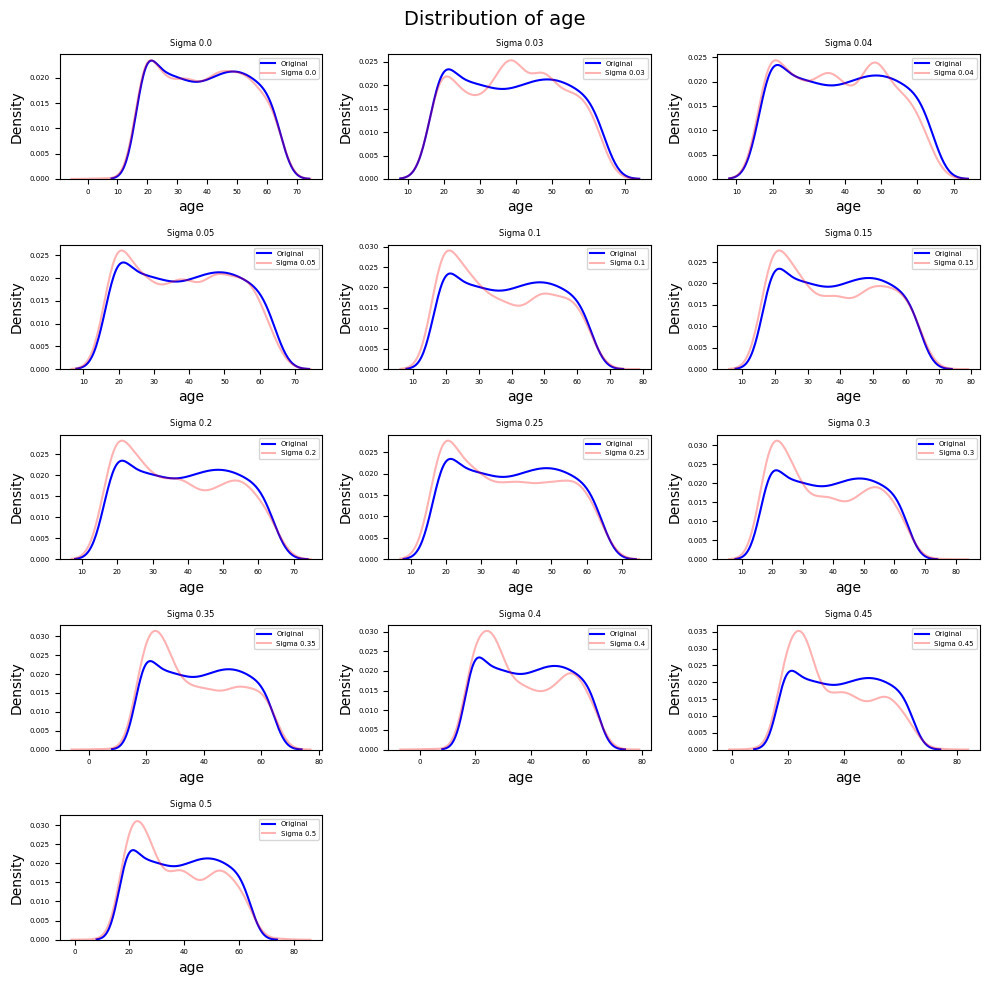

Under insurance-sigma-000.csv, removed 5 rows with outliers.
Under insurance-sigma-003.csv, removed 15 rows with outliers.
Under insurance-sigma-004.csv, removed 15 rows with outliers.


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

Under insurance-sigma-005.csv, removed 11 rows with outliers.
Under insurance-sigma-010.csv, removed 31 rows with outliers.
Under insurance-sigma-015.csv, removed 38 rows with outliers.
Under insurance-sigma-020.csv, removed 46 rows with outliers.


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

Under insurance-sigma-025.csv, removed 82 rows with outliers.
Under insurance-sigma-030.csv, removed 69 rows with outliers.
Under insurance-sigma-035.csv, removed 102 rows with outliers.
Under insurance-sigma-040.csv, removed 158 rows with outliers.


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

Under insurance-sigma-045.csv, removed 155 rows with outliers.
Under insurance-sigma-050.csv, removed 169 rows with outliers.


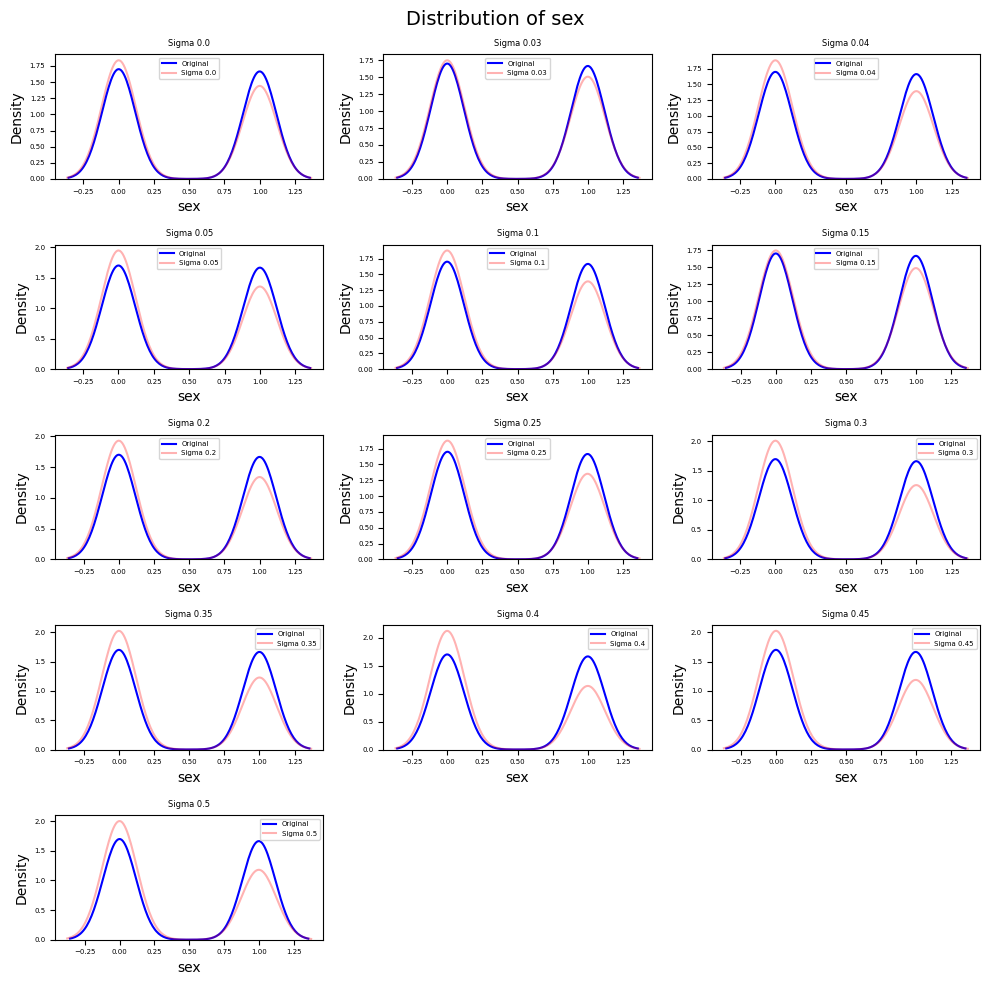

Under insurance-sigma-000.csv, removed 5 rows with outliers.
Under insurance-sigma-003.csv, removed 15 rows with outliers.
Under insurance-sigma-004.csv, removed 15 rows with outliers.


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

Under insurance-sigma-005.csv, removed 11 rows with outliers.
Under insurance-sigma-010.csv, removed 31 rows with outliers.
Under insurance-sigma-015.csv, removed 38 rows with outliers.
Under insurance-sigma-020.csv, removed 46 rows with outliers.


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

Under insurance-sigma-025.csv, removed 82 rows with outliers.
Under insurance-sigma-030.csv, removed 69 rows with outliers.
Under insurance-sigma-035.csv, removed 102 rows with outliers.


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

Under insurance-sigma-040.csv, removed 158 rows with outliers.
Under insurance-sigma-045.csv, removed 155 rows with outliers.
Under insurance-sigma-050.csv, removed 169 rows with outliers.


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


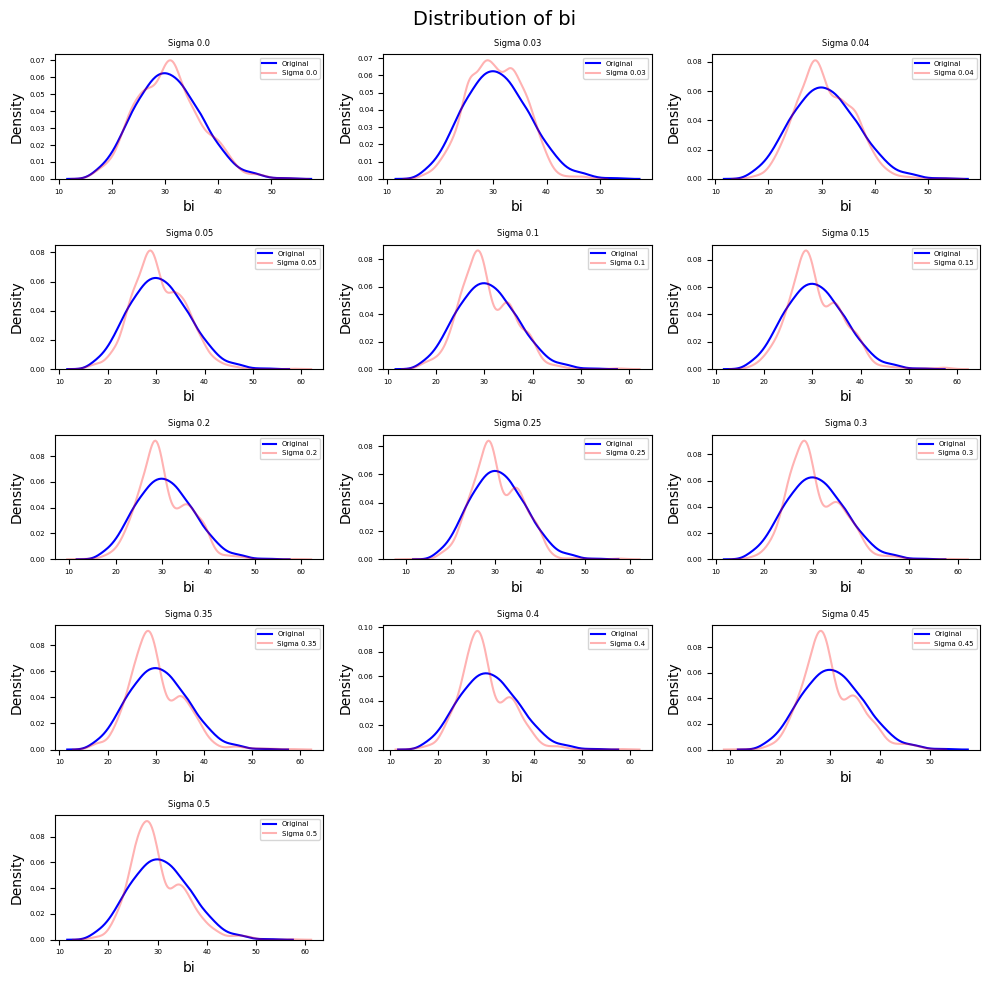

Under insurance-sigma-000.csv, removed 5 rows with outliers.
Under insurance-sigma-003.csv, removed 15 rows with outliers.
Under insurance-sigma-004.csv, removed 15 rows with outliers.


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

Under insurance-sigma-005.csv, removed 11 rows with outliers.
Under insurance-sigma-010.csv, removed 31 rows with outliers.
Under insurance-sigma-015.csv, removed 38 rows with outliers.
Under insurance-sigma-020.csv, removed 46 rows with outliers.


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

Under insurance-sigma-025.csv, removed 82 rows with outliers.
Under insurance-sigma-030.csv, removed 69 rows with outliers.
Under insurance-sigma-035.csv, removed 102 rows with outliers.
Under insurance-sigma-040.csv, removed 158 rows with outliers.


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

Under insurance-sigma-045.csv, removed 155 rows with outliers.
Under insurance-sigma-050.csv, removed 169 rows with outliers.


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

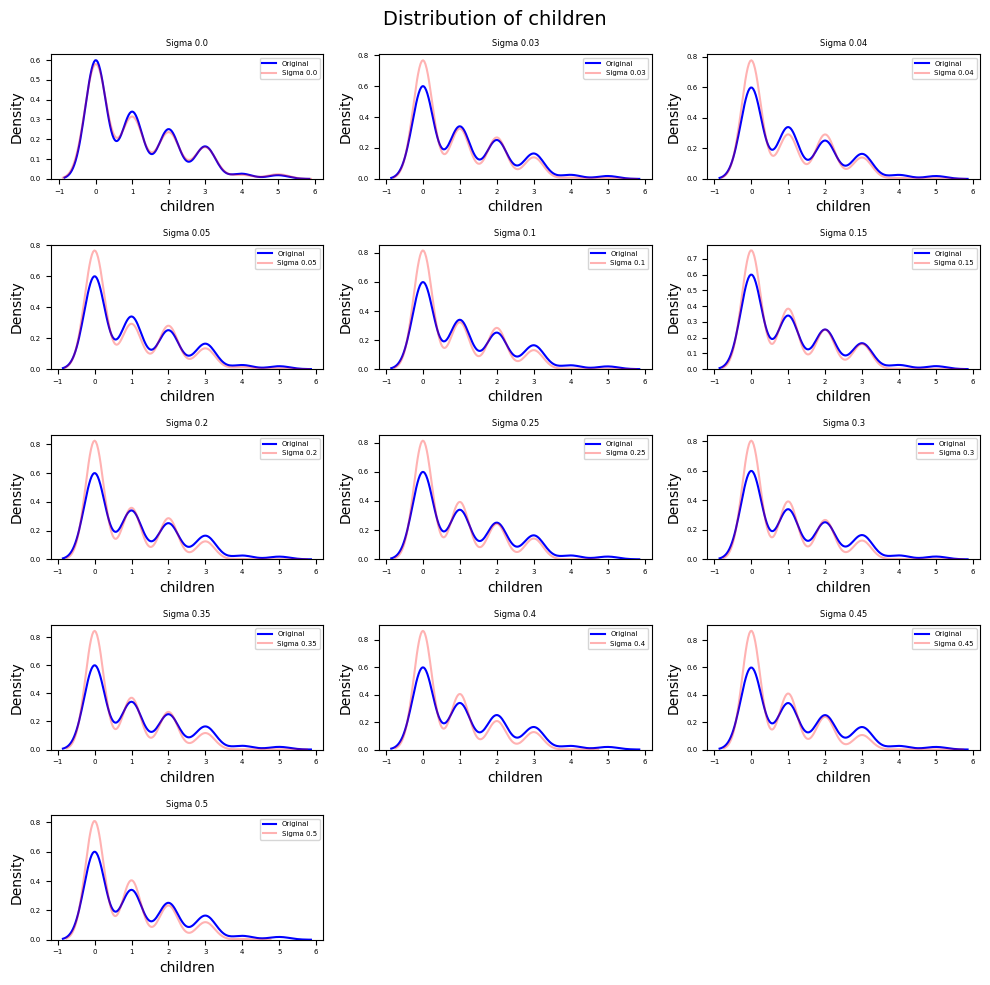

Under insurance-sigma-000.csv, removed 5 rows with outliers.
Under insurance-sigma-003.csv, removed 15 rows with outliers.
Under insurance-sigma-004.csv, removed 15 rows with outliers.


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

Under insurance-sigma-005.csv, removed 11 rows with outliers.
Under insurance-sigma-010.csv, removed 31 rows with outliers.
Under insurance-sigma-015.csv, removed 38 rows with outliers.
Under insurance-sigma-020.csv, removed 46 rows with outliers.


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

Under insurance-sigma-025.csv, removed 82 rows with outliers.
Under insurance-sigma-030.csv, removed 69 rows with outliers.
Under insurance-sigma-035.csv, removed 102 rows with outliers.
Under insurance-sigma-040.csv, removed 158 rows with outliers.
Under insurance-sigma-045.csv, removed 155 rows with outliers.


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

Under insurance-sigma-050.csv, removed 169 rows with outliers.


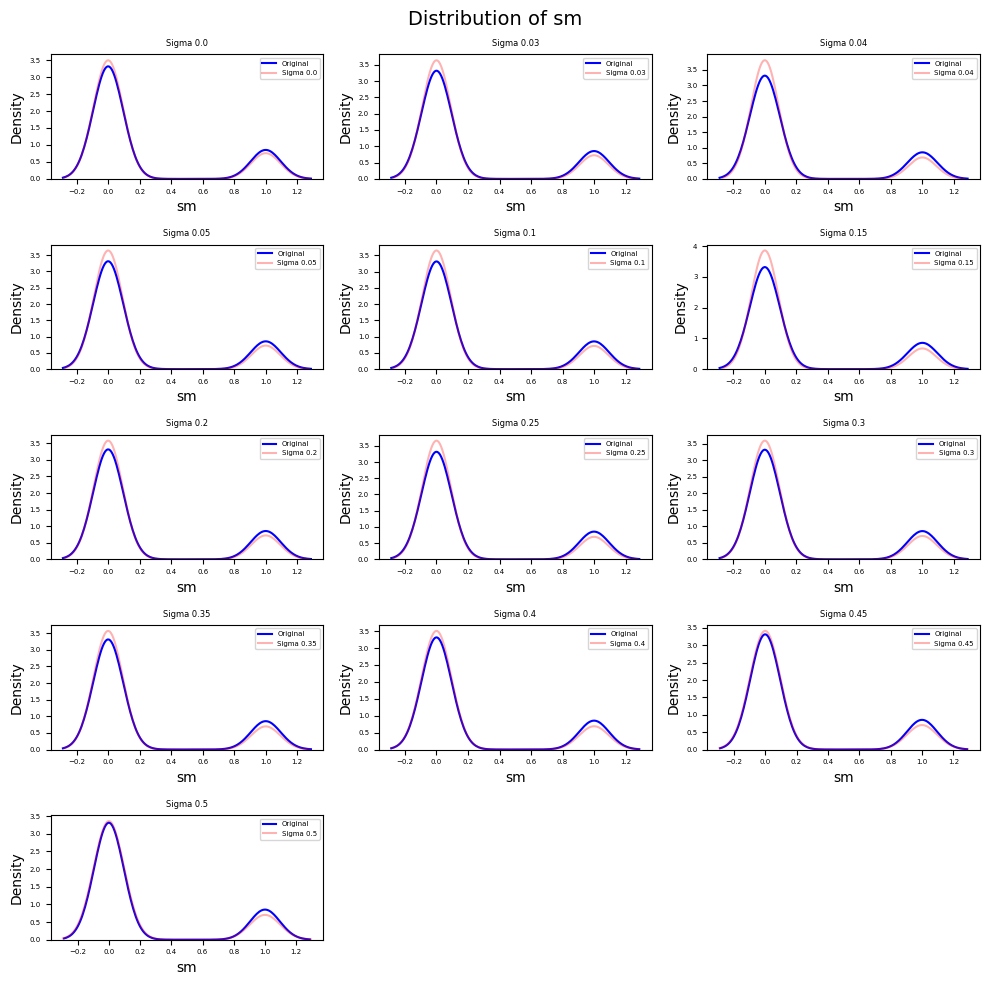

Under insurance-sigma-000.csv, removed 5 rows with outliers.
Under insurance-sigma-003.csv, removed 15 rows with outliers.
Under insurance-sigma-004.csv, removed 15 rows with outliers.


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

Under insurance-sigma-005.csv, removed 11 rows with outliers.
Under insurance-sigma-010.csv, removed 31 rows with outliers.
Under insurance-sigma-015.csv, removed 38 rows with outliers.
Under insurance-sigma-020.csv, removed 46 rows with outliers.


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

Under insurance-sigma-025.csv, removed 82 rows with outliers.
Under insurance-sigma-030.csv, removed 69 rows with outliers.
Under insurance-sigma-035.csv, removed 102 rows with outliers.
Under insurance-sigma-040.csv, removed 158 rows with outliers.


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

Under insurance-sigma-045.csv, removed 155 rows with outliers.
Under insurance-sigma-050.csv, removed 169 rows with outliers.


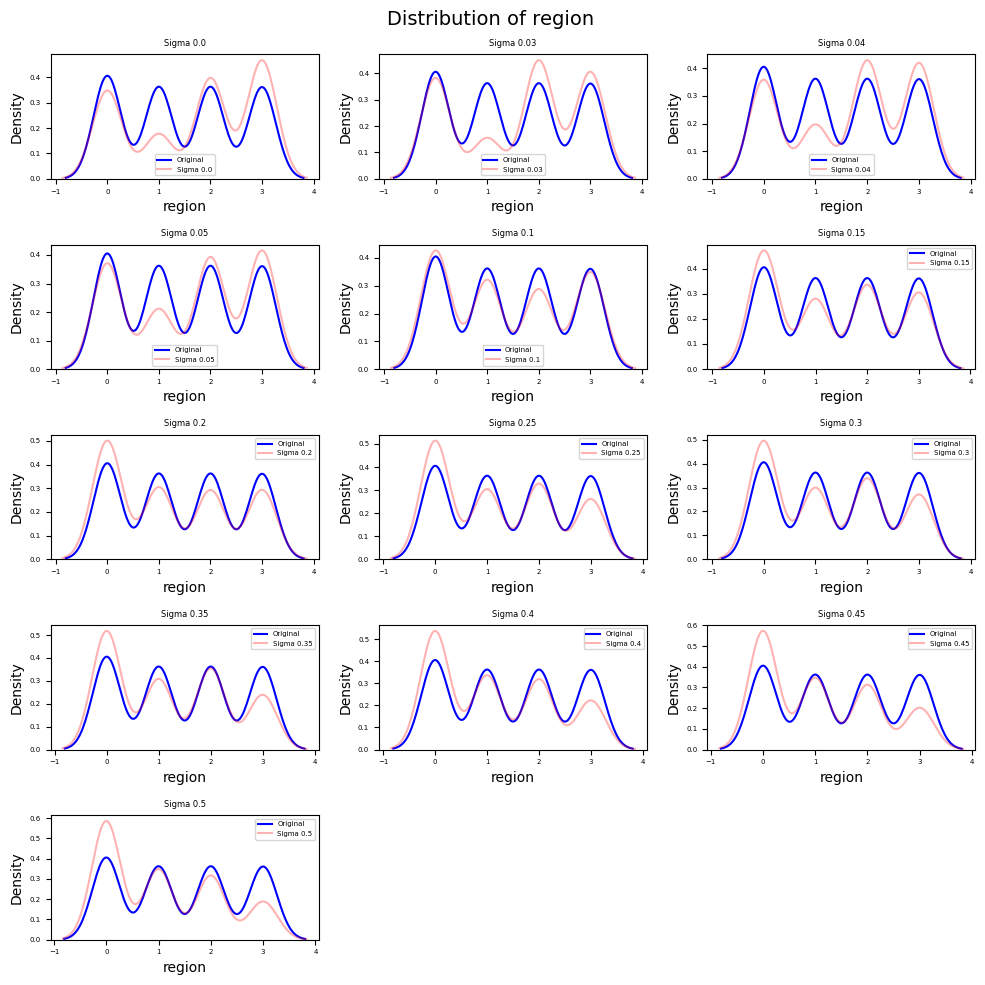

Under insurance-sigma-000.csv, removed 5 rows with outliers.
Under insurance-sigma-003.csv, removed 15 rows with outliers.
Under insurance-sigma-004.csv, removed 15 rows with outliers.
Under insurance-sigma-005.csv, removed 11 rows with outliers.


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

Under insurance-sigma-010.csv, removed 31 rows with outliers.
Under insurance-sigma-015.csv, removed 38 rows with outliers.
Under insurance-sigma-020.csv, removed 46 rows with outliers.
Under insurance-sigma-025.csv, removed 82 rows with outliers.
Under insurance-sigma-030.csv, removed 69 rows with outliers.


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

Under insurance-sigma-035.csv, removed 102 rows with outliers.
Under insurance-sigma-040.csv, removed 158 rows with outliers.
Under insurance-sigma-045.csv, removed 155 rows with outliers.
Under insurance-sigma-050.csv, removed 169 rows with outliers.


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


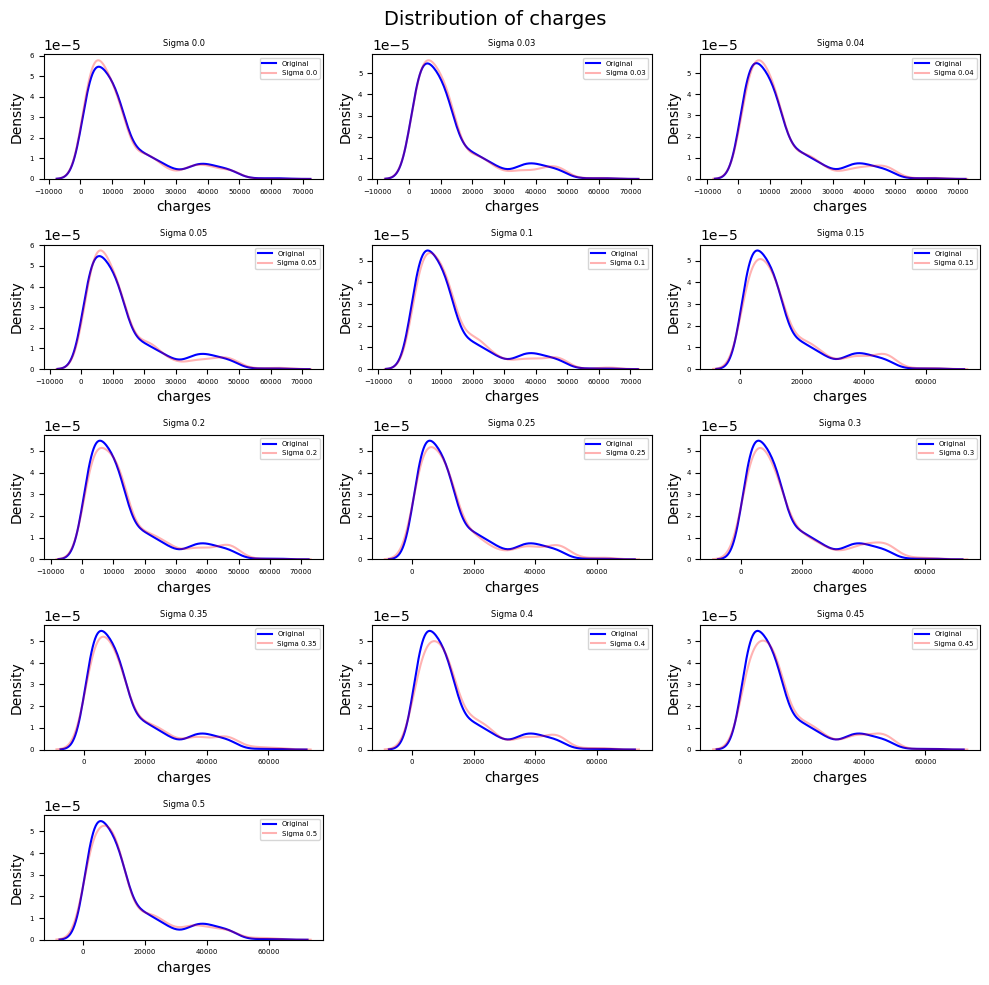

In [27]:
import os
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def extract_sigma(file_name):
    match = re.search(r"sigma-(\d+)", file_name)
    if match:
        sigma_str = match.group(1)
        if len(sigma_str) == 1:  # Single digit like "1" -> "1"
            return int(sigma_str)
        elif len(sigma_str) == 2:  # Two digits like "05" -> "0.5"
            return int(sigma_str) / 10
        elif len(sigma_str) == 3:  # Three digits like "005" -> "0.05"
            return int(sigma_str) / 100
    return None



def plot_comparison_for_each_column(original_data, synthetic_folder):
    """
    For each column, plot synthetic data with different sigma values against original data.
    """
    synthetic_files = [
        (file_name, extract_sigma(file_name))
        for file_name in os.listdir(synthetic_folder)
        if file_name.endswith(".csv") and extract_sigma(file_name) is not None
    ]

    # Sort files by sigma
    synthetic_files = sorted(synthetic_files, key=lambda x: x[1])

    # Iterate over each column
    for column in original_data.columns:
        # Adjust the number of rows and columns in the subplot grid
        num_files = len(synthetic_files)
        ncols = 3
        nrows = (num_files + ncols - 1) // ncols  # Ceiling division for rows

        fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10, 2 * nrows))

        # Flatten axes array for easy indexing
        axes = axes.flatten()

        for i, (file_name, sigma) in enumerate(synthetic_files):
            synthetic_path = os.path.join(synthetic_folder, file_name)
            synthetic_data = pd.read_csv(synthetic_path)
            # synthetic_data = replace_outliers_with_mean(original_data, synthetic_data, file_name)
            synthetic_data = remove_rows_with_outliers(original_data, synthetic_data, file_name)

            # Plot original and synthetic distributions
            sns.kdeplot(original_data[column], ax=axes[i], label='Original', color='blue')
            if column in synthetic_data.columns:
                sns.kdeplot(synthetic_data[column], ax=axes[i], label=f'Sigma {sigma}', color='red', alpha=0.3)

            axes[i].set_title(f'Sigma {sigma}', fontsize=6)
            axes[i].legend(fontsize=5)
            axes[i].tick_params(axis='both', which='major', labelsize=5)

        # Hide unused subplots
        for j in range(len(synthetic_files), len(axes)):
            axes[j].axis('off')

        fig.suptitle(f'Distribution of {column}', fontsize=14)
        plt.tight_layout()
        plt.show()



# Load original dataset
original_data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Tabula-main-claude/Real_Datasets/Insurance_compressed.csv")

# Path to synthetic datasets folder
synthetic_folder = "/content/drive/MyDrive/Colab Notebooks/Tabula-main-claude/insurance_syn_data"

# Generate plots
plot_comparison_for_each_column(original_data, synthetic_folder)
